In [3]:
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import warnings
pd.set_option('display.float_format', '{:0.8f}'.format)
import operator
import os, sys


# Get the path two folders up
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../"))
# Add the path to the sys.path
sys.path.append(path_to_add)

In [4]:
path_to_add = os.path.abspath(os.path.join(os.getcwd(), "../../daeFinder/"))
sys.path.append(path_to_add)

from dae_finder import solveMM, plotToy_MM, plotToyEnz

#### Plotting solutions to different IC

## Lorrenz Chaotic System

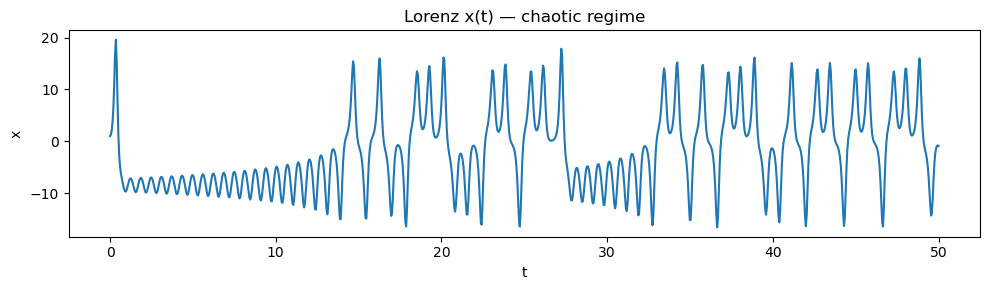

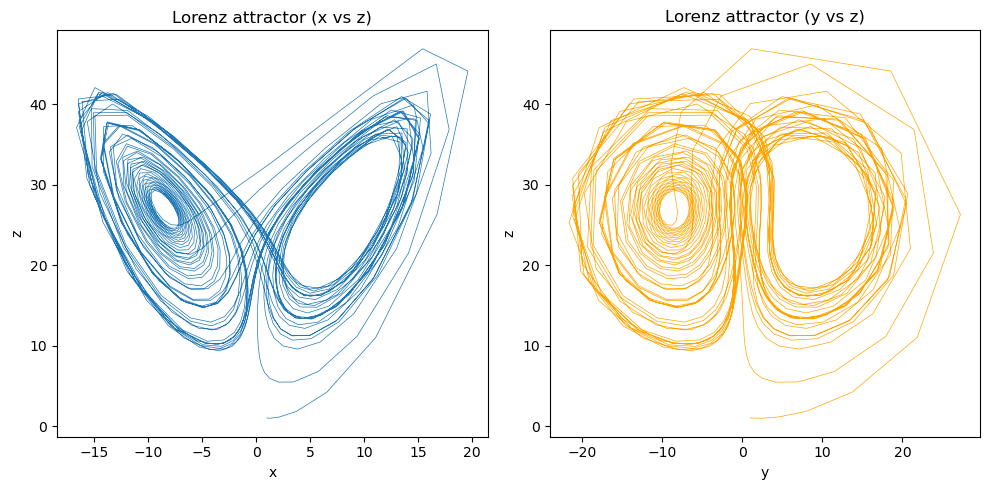

In [578]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def lorenz(t, state, sigma, rho, beta):
    x, y, z = state
    return [
        sigma * (y - x),
        x * (rho - z) - y,
        x * y - beta * z
    ]

# simulation settings
final_time      = 50.0
# final_time      = 5

num_time_points = 1000
t_span          = (0.0, final_time)
t_eval          = np.linspace(*t_span, num_time_points)

# classic Lorenz parameters (chaotic regime)
sigma, rho, beta = 10.0, 28.0, 8.0/3.0

# one “small” perturbation from the origin
IC = [1.0, 1.0, 1.0]

# solve
sol = solve_ivp(
    fun=lorenz,
    t_span=t_span,
    y0=IC,
    t_eval=t_eval,
    args=(sigma, rho, beta),
    method='RK45',
)

# put results in a DataFrame if you like
data_matrix_df = pd.DataFrame(sol.y.T, columns=['x','y','z'])
data_matrix_df['t'] = sol.t
data_matrix_df_list = [data_matrix_df]

# --- now plot! ---

# 1) the x(t) time series
plt.figure(figsize=(10,3))
plt.plot(sol.t, sol.y[0])
plt.title('Lorenz x(t) — chaotic regime')
plt.xlabel('t')
plt.ylabel('x')
plt.tight_layout()
plt.show()

# 2) the phase‐space portrait x vs z
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left subplot: x vs z
axs[0].plot(sol.y[0], sol.y[2], linewidth=0.5)
axs[0].set_title('Lorenz attractor (x vs z)')
axs[0].set_xlabel('x')
axs[0].set_ylabel('z')

# Right subplot: y vs z
axs[1].plot(sol.y[1], sol.y[2], linewidth=0.5, color='orange')
axs[1].set_title('Lorenz attractor (y vs z)')
axs[1].set_xlabel('y')
axs[1].set_ylabel('z')

plt.tight_layout()
plt.show()

from copy import deepcopy

data_matrix_df_orig = deepcopy(data_matrix_df_list[0])


<Axes: >

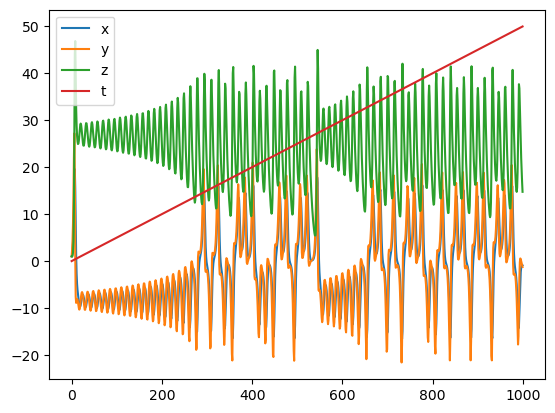

In [579]:
data_matrix_df.plot()

#### Adding noise

In [580]:
from dae_finder import add_noise_to_df
noise_perc = 0.01

data_matrix_df = deepcopy(data_matrix_df_orig)
for col in data_matrix_df.columns:
    if col != 't':
        data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)
t_exact = data_matrix_df["t"]

# data_matrix_features = data_matrix_df_list[0].columns
# for ind, data_matrix_ in enumerate(data_matrix_df_list):
#     # t_exact = data_matrix_["[t]"]
#     t_exact = data_matrix_["t"]
#     noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=111)
#     noisy_data_df["t"] = t_exact
#     data_matrix_df_list[ind] = noisy_data_df

In [581]:
data_matrix_df

,x,y,z,t
0,0.94307376,0.97861224,0.94496741,0.00000000
1,1.18065433,2.50823741,0.90564859,0.05005005
2,2.17110513,4.48998955,1.17176284,0.10010010
3,3.62389850,8.02499615,1.77388205,0.15015015
4,6.64392805,13.81974942,4.13168580,0.20020020
...,...,...,...,...
995,-2.27938858,0.28275843,24.99103019,49.79979980
996,-1.44497492,-0.09490439,21.92700233,49.84984985
997,-0.80413061,-0.44993306,19.19818926,49.89989990
998,-0.63026305,-0.70028868,16.89120226,49.94994995


# Defining Cadidate library (RHS of equations)

### Using polynomial features inspired from mass action kinetics

In [565]:
from dae_finder import PolyFeatureMatrix

poly_degree = 3

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)
candidate_lib_full

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,x^2 y,x^2 z,x y^2,x y z,x z^2,y^3,y^2 z,y z^2,z^3
0,0.98008940,0.98910291,0.98519976,0.96057524,0.96940928,0.96558385,0.97832457,0.97446395,0.97061857,0.94144962,0.95010777,0.94635850,0.95884554,0.95506179,0.95129297,0.96766368,0.96384513,0.96004165,0.95625318
1,1.37429702,2.40015854,1.01024425,1.88869230,3.29853074,1.38837567,5.76076104,2.42474637,1.02059345,2.59562421,4.53316097,1.90804054,7.91699674,3.33232172,1.40259853,13.82673983,5.81977572,2.44958608,1.03104866
2,2.19387117,4.53799086,1.21464905,4.81307072,9.95576732,2.66478354,20.59336103,5.51206630,1.47537232,10.55925710,21.84167092,5.84619179,45.17918109,12.09276335,3.23677680,93.45248409,25.01370647,6.69522611,1.79205959
3,3.95251902,8.03320193,1.87337906,15.62240662,31.75138342,7.40456636,64.53233320,15.04923225,3.50954909,61.74785933,125.49794696,29.26668939,255.06527451,59.48237675,13.87155955,518.40126345,120.89352155,28.19291654,6.57471577
4,6.70055893,13.94647633,4.41160844,44.89748999,93.44918652,29.56024235,194.50420200,61.52639271,19.46228905,300.83827752,626.16178135,198.07014586,1303.28686781,412.26122018,130.40821469,2712.64824906,858.07637956,271.43035350,85.85999866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-8.59338900,-6.58866632,29.70450611,73.84633452,56.61897265,-255.26237612,43.41052383,-195.71307889,882.35768353,-634.59027880,-486.54885685,2193.56889526,-373.04351801,1681.83861945,-7582.44281234,-286.01745616,1289.48817061,-5813.56034867,26209.99920575
96,-7.64829338,-5.86567224,28.26963539,58.49639168,44.86238216,-216.21446534,34.40611079,-165.82041548,799.17228531,-447.39756547,-343.12066065,1653.67166473,-263.14802952,1268.24318658,-6112.30410211,-201.81496885,972.64820739,-4687.68268646,22592.30912254
97,-6.89798774,-5.70961683,26.58589585,47.58223490,39.38486689,-183.38918370,32.59972430,-151.79527828,706.80985810,-328.22167314,-271.67632903,1265.01634137,-224.87249867,1047.08196905,-4875.56573779,-186.13193442,866.69287506,-4035.61345887,18791.17327263
98,-6.62523575,-6.23144054,25.15575420,43.89374869,41.28476262,-166.66280195,38.83085122,-156.75658659,632.81196946,-290.80643281,-273.52128509,1104.18035296,-257.26354356,1038.54934083,-4192.52848043,-241.97214057,976.81934880,-3943.33016167,15918.86235980


## Scaling the candidate library for numerical stability of optmizers.

- Some regularization methods like Lasso require the features to be on the same scale.
- We keep a version of the candidate library that is scaled to have std =1. 

In [437]:
#scaling the candidate columns to set std of 1
from sklearn.preprocessing import normalize
scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

In [438]:
# #scaling the candidate columns to set std of 1
# from sklearn.preprocessing import StandardScaler
# s_scaler = StandardScaler(with_std=True, with_mean=False)
# scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
# if '1' in scaled_cand_lib.columns:
#         scaled_cand_lib['1'] = 1

In [439]:
scaled_cand_lib.describe()

,x,y,z,x^2,x y,x z,y^2,y z,z^2,x^3,x^2 y,x^2 z,x y^2,x y z,x z^2,y^3,y^2 z,y z^2,z^3
count,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000,1000.00000000
mean,-0.00780919,-0.00700301,0.02997574,0.02192356,0.02025315,-0.00690383,0.01941476,-0.00721818,0.02686636,-0.00371016,-0.00349102,0.01967047,-0.00280012,0.01860731,-0.00554550,-0.00210435,0.01839611,-0.00647069,0.02365112
std,0.03065871,0.03085303,0.01007753,0.02280082,0.02429816,0.03087540,0.02497380,0.03080336,0.01668763,0.03142009,0.03144522,0.02477269,0.03151432,0.02558168,0.03114832,0.03156847,0.02573413,0.03096917,0.02100156
min,-0.06551935,-0.07617816,0.00120736,0.00000091,-0.01807595,-0.08613347,0.00000009,-0.08904197,0.00003916,-0.11858201,-0.12470765,0.00000063,-0.13293344,-0.02421675,-0.10394723,-0.14063150,0.00000007,-0.10996607,0.00000115
25%,-0.03183180,-0.02854233,0.02198538,0.00296675,0.00134699,-0.02615961,0.00169861,-0.02592809,0.01298605,-0.01359892,-0.01176057,0.00147856,-0.00967439,0.00092758,-0.02034148,-0.00739717,0.00133708,-0.02143987,0.00696082
50%,-0.01179318,-0.00922107,0.03002016,0.01503393,0.01165722,-0.00656327,0.00926423,-0.00672508,0.02421224,-0.00069185,-0.00041036,0.01000920,-0.00034159,0.00845374,-0.00319355,-0.00024942,0.00737714,-0.00422815,0.01772134
75%,0.01154381,0.00958787,0.03700998,0.03378366,0.03120737,0.00647345,0.02730684,0.00748053,0.03679991,0.00064859,0.00045597,0.02866853,0.00029714,0.02743340,0.00348311,0.00028042,0.02489303,0.00460498,0.03320584
max,0.07724667,0.09549603,0.05831310,0.13081897,0.14166154,0.11220864,0.17705272,0.11115850,0.09135685,0.19433425,0.18104926,0.17612974,0.23462229,0.17392079,0.14764953,0.27704294,0.17687040,0.16412920,0.12988406


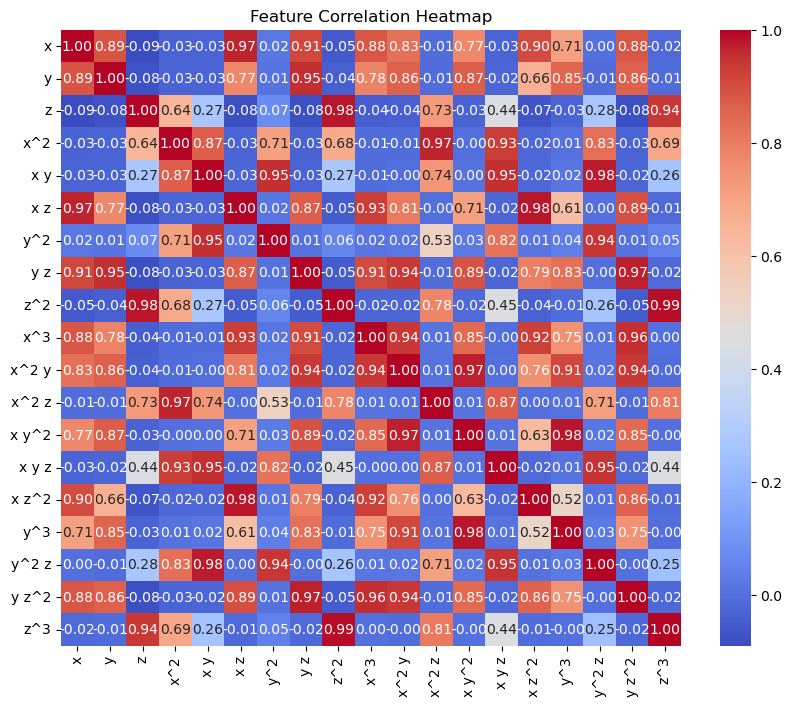

,Feature 1,Feature 2,Correlation
350,z^3,z^2,0.98734703
170,z^2,z^3,0.98734703
109,x z,x z^2,0.98194910
271,x z^2,x z,0.98194910
297,y^3,x y^2,0.98130663
243,x y^2,y^3,0.98130663
154,z^2,z,0.98052972
46,z,z^2,0.98052972
308,y^2 z,x y,0.97775068
92,x y,y^2 z,0.97775068


In [440]:
import seaborn as sns

import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = scaled_cand_lib.corr()

# Flatten the correlation matrix and sort by absolute correlation values
correlation_pairs = correlation_matrix.unstack().reset_index()
correlation_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']
correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]
sorted_correlation_pairs = correlation_pairs.reindex(correlation_pairs['Correlation'].abs().sort_values(ascending=False).index)

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Display sorted correlation pairs
sorted_correlation_pairs.head(10)

In [441]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(candidate_lib_full['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(candidate_lib_full, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-12.897447076110385), 'y': np.float64(11.83451079598406), 'z': np.float64(-0.2013741069065327), 'x^2': np.float64(-0.04595256285969476), 'x y': np.float64(0.1063862197538493), 'x z': np.float64(0.22212129644097803), 'y^2': np.float64(-0.04472235836008146), 'y z': np.float64(-0.12803915649136086), 'z^2': np.float64(0.0012788867630976473), 'x^3': np.float64(0.02162722162440322), 'x^2 y': np.float64(-0.030430083655119497), 'x^2 z': np.float64(-0.0003782005559339335), 'x y^2': np.float64(0.01222207579891805), 'x y z': np.float64(-0.0014182070596644462), 'x z^2': np.float64(-0.004764023734523344), 'y^3': np.float64(-0.002248089148614099), 'y^2 z': np.float64(0.000865164979643839), 'y z^2': np.float64(0.002681106429306177), 'z^3': np.float64(0.00017186532653520287)}


In [442]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-12.897447076113941), 'y': np.float64(13.234652887035836), 'z': np.float64(-0.6373036877084556), 'x^2': np.float64(-0.5331584708326107), 'x y': np.float64(1.3354979893789463), 'x z': np.float64(6.780458734328664), 'y^2': np.float64(-0.732782202851068), 'y z': np.float64(-3.7294133927969244), 'z^2': np.float64(0.12127367199969301), 'x^3': np.float64(3.318991794052267), 'x^2 y': np.float64(-4.977123942926838), 'x^2 z': np.float64(-0.14451807407980394), 'x y^2': np.float64(2.5164643440819314), 'x y z': np.float64(-0.5187594910238311), 'x z^2': np.float64(-4.900635736201648), 'y^3': np.float64(-0.6394764109678951), 'y^2 z': np.float64(0.37236125841274437), 'y z^2': np.float64(2.3452221718348913), 'z^3': np.float64(0.5381144061506966)}


In [443]:
from sklearn.linear_model import LinearRegression

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
lin_model = LinearRegression()
lin_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
print(coefficients)
x = lin_model.coef_

{'x': np.float64(-12.897447076113941), 'y': np.float64(13.234652887035836), 'z': np.float64(-0.6373036877084556), 'x^2': np.float64(-0.5331584708326107), 'x y': np.float64(1.3354979893789463), 'x z': np.float64(6.780458734328664), 'y^2': np.float64(-0.732782202851068), 'y z': np.float64(-3.7294133927969244), 'z^2': np.float64(0.12127367199969301), 'x^3': np.float64(3.318991794052267), 'x^2 y': np.float64(-4.977123942926838), 'x^2 z': np.float64(-0.14451807407980394), 'x y^2': np.float64(2.5164643440819314), 'x y z': np.float64(-0.5187594910238311), 'x z^2': np.float64(-4.900635736201648), 'y^3': np.float64(-0.6394764109678951), 'y^2 z': np.float64(0.37236125841274437), 'y z^2': np.float64(2.3452221718348913), 'z^3': np.float64(0.5381144061506966)}


In [444]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

# Compute the derivative of x using finite differences
dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)

# Convert the result to a pandas Series for easier handling
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')

# Display the derivative
# print(dx_dt_series)


# Fit the derivative series against the scaled candidate library
# Fit the derivative series against the scaled candidate library using Ridge regression
ridge_model = Ridge(alpha=0.3)
ridge_model.fit(scaled_cand_lib, dx_dt_series)

# Display the coefficients of the features
coefficients = dict(zip(scaled_cand_lib.columns, ridge_model.coef_))

print(coefficients)
x = ridge_model.coef_

{'x': np.float64(-0.6581171064623688), 'y': np.float64(2.0561302604258027), 'z': np.float64(0.009713583198688105), 'x^2': np.float64(0.027170459062238292), 'x y': np.float64(0.016028432761250183), 'x z': np.float64(-1.5461666178359967), 'y^2': np.float64(-0.060034180891993916), 'y z': np.float64(1.123941637568914), 'z^2': np.float64(0.020506181758345034), 'x^3': np.float64(-0.6259982991812311), 'x^2 y': np.float64(0.3090061102759972), 'x^2 z': np.float64(0.01658464528336339), 'x y^2': np.float64(0.6031231080301191), 'x y z': np.float64(0.02342841424030134), 'x z^2': np.float64(-1.9313119714289952), 'y^3': np.float64(0.9219300718228159), 'y^2 z': np.float64(-0.07934337190564993), 'y z^2': np.float64(0.4875780023599747), 'z^3': np.float64(0.0082118344425137)}


## Testing illconditioning of the STOLS problem

In [445]:
# Defining STOLS

def stols(coefficients, pd_dict = True, threshold=0.1):
    """
    Selects features based on a threshold applied to the absolute values of coefficients.
    
    Parameters:
    coefficients (dict): Dictionary of feature names and their corresponding coefficients.
    threshold (float): Threshold value for selecting features.
    
    Returns:
    list: List of selected feature names.
    """
    selected_features = {feature: coef for feature, coef in coefficients.items() if abs(coef) > threshold}
    if pd_dict:
        return pd.DataFrame.from_dict(selected_features, orient='index', columns=['Coefficient']) 
    else:
        return selected_features

In [446]:
stols_df = stols(coefficients, pd_dict=True, threshold=0.1)

In [447]:
## Using scaled_cand_lib

In [448]:
stols_df

,Coefficient
x,-0.65811711
y,2.05613026
x z,-1.54616662
y z,1.12394164
x^3,-0.62599830
x^2 y,0.30900611
x y^2,0.60312311
x z^2,-1.93131197
y^3,0.92193007
y z^2,0.48757800


## Scaled candidate library (Term size based thresholding):

In [947]:
A = scaled_cand_lib.to_numpy()
# A = candidate_lib_full.to_numpy()

a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)
S

array([3.17690678e+01, 4.76701974e+00, 3.70226310e+00, 1.88031803e+00,
       1.74235237e+00, 1.00054947e+00, 7.64501205e-01, 6.49264595e-01,
       5.29400424e-01, 3.78739476e-01, 3.13626707e-01, 2.61699182e-01,
       2.01649159e-01, 1.63364881e-01, 1.48162448e-01, 1.19824176e-01,
       7.91945724e-02, 7.47642221e-02, 5.55806549e-02, 4.86180970e-02,
       4.13600276e-02, 3.62409040e-02, 2.45059929e-02, 2.22066979e-02,
       1.64317638e-02, 1.37404389e-02, 1.33506164e-02, 9.55320733e-03,
       8.52990472e-03, 7.67424685e-03, 5.31566071e-03, 4.55785371e-03,
       4.11451538e-03, 3.49244298e-03, 3.02806275e-03, 2.10410071e-03,
       1.73346317e-03, 1.42025762e-03, 1.20361609e-03, 1.08517094e-03,
       8.29939855e-04, 6.15689739e-04, 4.98813569e-04, 3.52931846e-04,
       3.01624477e-04, 2.64359401e-04, 2.26663994e-04, 2.03447658e-04,
       1.46296468e-04, 1.08882937e-04, 7.23121869e-05, 6.51675224e-05,
       3.86262794e-05, 3.39997219e-05, 2.45186870e-05, 2.10862754e-05])

In [934]:
from scipy.linalg import qr
import numpy as np

# Compute the pivoted QR decomposition of A_design
Q, R, P = qr(A_design, mode='economic', pivoting=True)
# Q, R = qr(A_design, mode='economic', pivoting=False)
# Q, R, P = qr(A, mode='economic', pivoting=True)

# Q: orthogonal matrix, R: upper triangular matrix, P: pivot indice

In [935]:
np.arange(0,R.shape[0])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55])

In [937]:
for i, r_ii in enumerate(np.diag(R)):
    print(f"R[{i},{i}] = {r_ii}")

R[0,0] = -31.622776601683793
R[1,1] = -0.999995070426868
R[2,2] = -0.962143075524324
R[3,3] = 0.9030386824673046
R[4,4] = 0.8097216831937316
R[5,5] = 0.6527966928772483
R[6,6] = 0.4939728597147641
R[7,7] = -0.46064526407671513
R[8,8] = -0.3496180547105131
R[9,9] = 0.2413616181975775
R[10,10] = -0.21645022594822974
R[11,11] = -0.1993460741005816
R[12,12] = -0.13772604948488051
R[13,13] = -0.12986996870385603
R[14,14] = 0.10629598637812888
R[15,15] = 0.09029184105578197
R[16,16] = 0.08037464073908378
R[17,17] = -0.04941402604600015
R[18,18] = -0.045424410613659705
R[19,19] = 0.04265640213756242
R[20,20] = -0.041992714441508046
R[21,21] = -0.036141874318171216
R[22,22] = 0.020158863612386255
R[23,23] = -0.02001269208915439
R[24,24] = 0.016428299407760864
R[25,25] = 0.014872436909027455
R[26,26] = -0.01245089873352575
R[27,27] = -0.01116837905778541
R[28,28] = -0.010343716895001152
R[29,29] = 0.008336112454644476
R[30,30] = 0.006641403013335068
R[31,31] = -0.005880920316157364
R[32,32] = -

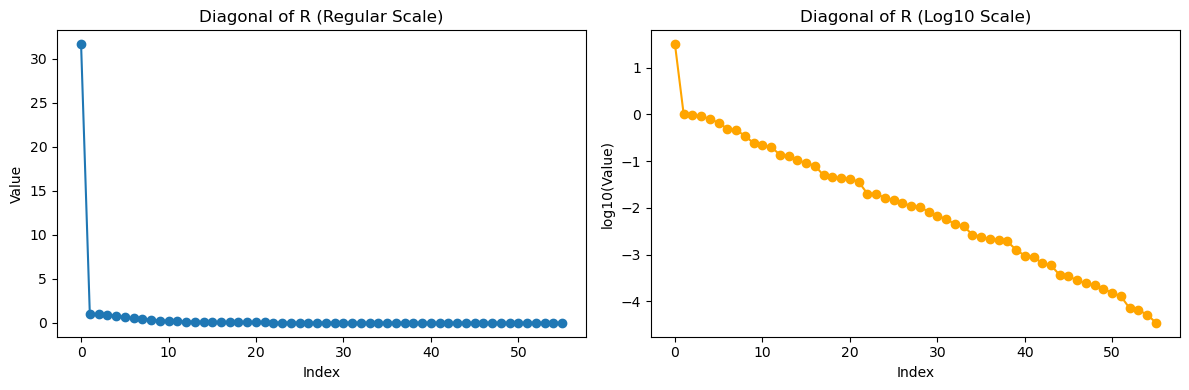

In [938]:
import matplotlib.pyplot as plt

diag_R = np.abs(np.diag(R))

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Regular scale
axs[0].plot(diag_R, marker='o')
axs[0].set_title('Diagonal of R (Regular Scale)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Log scale
axs[1].plot(np.log10(np.abs(diag_R)), marker='o', color='orange')
axs[1].set_title('Diagonal of R (Log10 Scale)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('log10(Value)')

plt.tight_layout()
plt.show()

In [939]:
P

array([ 0, 50, 49, 51, 55,  2, 48, 47,  7, 54,  6,  9, 16, 53,  4, 18, 30,
       52, 17, 37, 35, 11, 39,  3, 20, 46, 31, 41,  1,  8, 44, 10, 23, 43,
       22,  5, 32, 45, 40, 19, 42, 36, 28, 27, 15, 13, 12, 33, 21, 26, 14,
       38, 24, 34, 25, 29], dtype=int32)

In [940]:
col = candidate_lib_full.columns
col = np.array(['1'] + list(col))
col[P]

array(['1', 'y^5', 'x z^4', 'y^4 z', 'z^5', 'y', 'x y z^3', 'x y^2 z^2',
       'y^2', 'y z^4', 'x z', 'z^2', 'y^3', 'y^2 z^3', 'x^2', 'y z^2',
       'y^4', 'y^3 z^2', 'y^2 z', 'x^4 z', 'x^5', 'x^2 y', 'x^3 y z', 'z',
       'x^4', 'x y^3 z', 'y^3 z', 'x^2 y^3', 'x', 'y z', 'x^2 z^3', 'x^3',
       'x^2 y^2', 'x^2 y z^2', 'x^3 z', 'x y', 'y^2 z^2', 'x y^4',
       'x^3 z^2', 'z^3', 'x^2 y^2 z', 'x^4 y', 'x y z^2', 'x y^2 z',
       'x z^2', 'x y^2', 'x^2 z', 'y z^3', 'x^3 y', 'x y^3', 'x y z',
       'x^3 y^2', 'x^2 y z', 'z^4', 'x^2 z^2', 'x z^3'], dtype='<U9')

In [941]:
col = candidate_lib_full.columns
col = np.array(['1'] + list(col))
col[P]

for ind, col_ in enumerate(col[P]):
    print("{}: {}".format(ind,col_))

0: 1
1: y^5
2: x z^4
3: y^4 z
4: z^5
5: y
6: x y z^3
7: x y^2 z^2
8: y^2
9: y z^4
10: x z
11: z^2
12: y^3
13: y^2 z^3
14: x^2
15: y z^2
16: y^4
17: y^3 z^2
18: y^2 z
19: x^4 z
20: x^5
21: x^2 y
22: x^3 y z
23: z
24: x^4
25: x y^3 z
26: y^3 z
27: x^2 y^3
28: x
29: y z
30: x^2 z^3
31: x^3
32: x^2 y^2
33: x^2 y z^2
34: x^3 z
35: x y
36: y^2 z^2
37: x y^4
38: x^3 z^2
39: z^3
40: x^2 y^2 z
41: x^4 y
42: x y z^2
43: x y^2 z
44: x z^2
45: x y^2
46: x^2 z
47: y z^3
48: x^3 y
49: x y^3
50: x y z
51: x^3 y^2
52: x^2 y z
53: z^4
54: x^2 z^2
55: x z^3


### Using 1 as one of the features

In [942]:
# Use the scaled_cand_lib to get the columns 'x', 'y', 'z'
x_vals = scaled_cand_lib['x'].values
y_vals = scaled_cand_lib['y'].values
z_vals = scaled_cand_lib['z'].values

# x_vals =  candidate_lib_full['x'].values
# y_vals = candidate_lib_full['y'].values
# z_vals = candidate_lib_full['z'].values

# Lorenz parameters (already defined above)
# sigma, rho, beta = 10.0, 28.0, 8.0/3.0

# Compute dx/dt using the Lorenz function for each row
dx_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[0]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])
dy_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[1]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])

dz_dt_lorenz = np.array([
    lorenz(0, [x, y, z], sigma, rho, beta)[2]
    for x, y, z in zip(x_vals, y_vals, z_vals)
])


# Apply a simple moving average smoothing to x_vals before computing the gradient
window_size = 2
x_smooth = np.convolve(x_vals, np.ones(window_size)/window_size, mode='same')
dx_dt_finite_diff = np.gradient(x_smooth, t_exact)

y_smooth = np.convolve(y_vals, np.ones(window_size)/window_size, mode='same')
dy_dt_finite_diff = np.gradient(y_smooth, t_exact)

from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter to smooth x_vals before computing the gradient
window_length = 7  # should be odd and less than the size of x_vals
polyorder = 3
# x_smooth = savgol_filter(x_vals, window_length, polyorder)
# dx_dt_svgol_filter = np.gradient(x_smooth, t_exact)

y_smooth = savgol_filter(y_vals, window_length, polyorder)
dy_dt_svgol_filter = np.gradient(y_smooth, t_exact)

z_smooth = savgol_filter(z_vals, window_length, polyorder)
dz_dt_svgol_filter = np.gradient(z_smooth, t_exact)

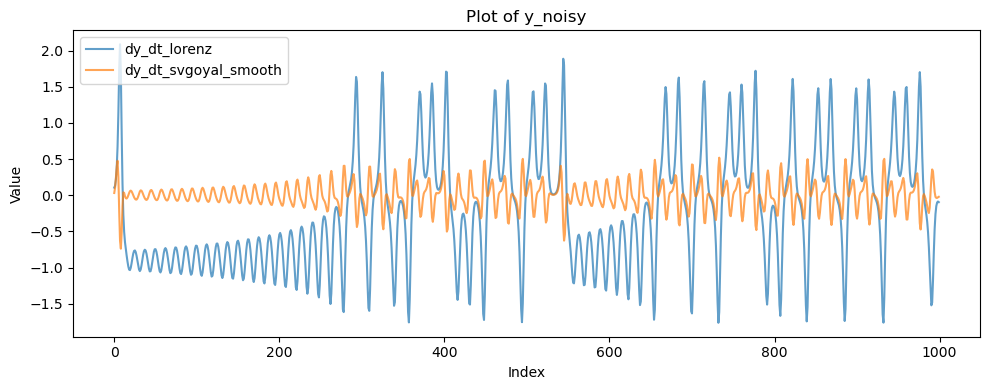

In [943]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
# plt.plot(y, label='y_noisy')
# plt.plot(dx_dt_lorenz, label='dx_dt_lorenz', alpha=0.7)
plt.plot(dy_dt_lorenz, label='dy_dt_lorenz', alpha=0.7)

# plt.plot(dy_dt_finite_diff, label='dy_dt_fd_smooth', alpha=0.7)
# plt.plot(dx_dt_svgol_filter, label='dx_dt_svgoyal_smooth', alpha=0.7)
plt.plot(dy_dt_svgol_filter, label='dy_dt_svgoyal_smooth', alpha=0.7)




plt.title('Plot of y_noisy')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.tight_layout()
plt.show()

In [944]:
# Number of independendent columns
L_ind = 35
print(" Independent columns: ", col[P][:L_ind])
# print(list(zip(candidate_lib_full.columns[P][:L_ind], np.diag(R)[:L_ind])))
col = candidate_lib_full.columns
col = np.array(['1'] + list(col))
# b = y_noisy
# b = dx_dt_lorenz
# b = dy_dt_lorenz
# b = dx_dt_finite_diff
# b = dx_dt_svgol_filter
b = dy_dt_svgol_filter



b_proj = np.zeros(b.shape)
b_proj_cord_list = []
for i in range(L_ind):
    print("iteration: ", i)
    b_proj_cord = Q[:, i].T @ b
    b_proj_cord_list.append(b_proj_cord)
    # b_proj += b_proj_cord * Q[:, i]
    b_proj += b_proj_cord * Q[:, i]

    print("R value for feature {}: {}".format(col[P][i], R[i,i]))
    print("Residual norm: {}".format(np.linalg.norm(b - b_proj)/np.linalg.norm(b)))

model_dict_proj = dict(zip(col[P[:L_ind]], np.linalg.solve(R[:L_ind, :L_ind], b_proj_cord_list)))
model_proj_thresh =  stols(model_dict_proj, pd_dict=True, threshold=0.01)
model_proj_thresh

 Independent columns:  ['1' 'y^5' 'x z^4' 'y^4 z' 'z^5' 'y' 'x y z^3' 'x y^2 z^2' 'y^2' 'y z^4'
 'x z' 'z^2' 'y^3' 'y^2 z^3' 'x^2' 'y z^2' 'y^4' 'y^3 z^2' 'y^2 z' 'x^4 z'
 'x^5' 'x^2 y' 'x^3 y z' 'z' 'x^4' 'x y^3 z' 'y^3 z' 'x^2 y^3' 'x' 'y z'
 'x^2 z^3' 'x^3' 'x^2 y^2' 'x^2 y z^2' 'x^3 z']
iteration:  0
R value for feature 1: -31.622776601683793
Residual norm: 0.999999548677538
iteration:  1
R value for feature y^5: -0.999995070426868
Residual norm: 0.9954703778759909
iteration:  2
R value for feature x z^4: -0.962143075524324
Residual norm: 0.6303420383284962
iteration:  3
R value for feature y^4 z: 0.9030386824673046
Residual norm: 0.630334711005691
iteration:  4
R value for feature z^5: 0.8097216831937316
Residual norm: 0.6287723576543908
iteration:  5
R value for feature y: 0.6527966928772483
Residual norm: 0.3975738357712868
iteration:  6
R value for feature x y z^3: 0.4939728597147641
Residual norm: 0.39756836679084073
iteration:  7
R value for feature x y^2 z^2: -0.460645264076

,Coefficient
1,-0.05133119
y^5,0.84803149
x z^4,-1.54509003
y^4 z,2.90964376
z^5,4.48885597
y,-4.15217702
x y z^3,4.31236367
x y^2 z^2,1.45908768
y^2,0.97220968
y z^4,1.09220756


In [922]:
np.array(b_proj_cord_list).reshape(-1, 1)

array([[ 0.00533214],
       [ 0.42663282],
       [-0.01742835],
       [ 4.55594886],
       [ 0.17137948],
       [ 2.93345678],
       [-0.59967648],
       [-0.05800502],
       [ 0.01795049],
       [-0.00922282],
       [ 0.59463788],
       [-0.21241283],
       [ 0.11698489],
       [-1.26662365],
       [-0.04702312],
       [-0.09179088],
       [-0.32158452],
       [-0.63713743],
       [ 0.15873007],
       [ 0.01015397],
       [ 0.02382232],
       [-0.02553972],
       [ 0.05997797],
       [ 0.25892882],
       [-0.0338409 ]])

In [923]:
np.zeros(R.shape[1]-L_ind).shape

(10,)

In [924]:
#Assembling C matrix to represent family of solutions: see Lemma 1 in manuscript 

R_1 = R[:L_ind, :L_ind]
R_2 = R[:L_ind:, L_ind:]

C_1 = np.hstack([np.array(b_proj_cord_list), np.zeros(R.shape[1]-L_ind)])

C_0 = np.linalg.solve(R_1, R_2)
C_2 = np.vstack([C_0, np.eye(C_0.shape[1])])

R_1.shape, R_2.shape, C_1.shape,  C_0.shape, C_2.shape

((25, 25), (25, 10), (35,), (25, 10), (35, 10))

In [925]:
from scipy.optimize import minimize, LinearConstraint, Bounds
import numpy as np

# alpha is a vector of length R.shape[1] - L_ind
alpha_dim = R.shape[1] - L_ind

def cost(alpha, penalty=1e-3):
    b_new = (C_1 + C_2 @ alpha).flatten()
    return penalty*np.sum(np.abs(b_new))  # l1 norm

def eq_constraint(alpha):
    b_new = (C_1 + C_2 @ alpha).flatten()
    # return [b_new[9], b_new[10]]
    return [b_new[0]]


def ineq_constraint(alpha):
    b_new = (C_1 + C_2 @ alpha).flatten()
    # return [b_new[27] - 3, b_new[29] - 3]
    return [-b_new[29] - 15]


constraints = [
    {'type': 'eq', 'fun': eq_constraint},
    {'type': 'ineq', 'fun': ineq_constraint}
]

# Optionally, you can add bounds for alpha if needed
bounds = Bounds([-np.inf]*alpha_dim, [np.inf]*alpha_dim)

# Initial guess
alpha0 = np.zeros(alpha_dim)

# result = minimize(cost, alpha0, constraints=constraints, bounds=bounds, method='SLSQP')
result = minimize(cost, alpha0, constraints=constraints, bounds=bounds, method='SLSQP')


print("Optimal alpha:", result.x)
print("Optimal cost:", result.fun)
print("b_new:", (C_1 + C_2 @ result.x).flatten())

Optimal alpha: [ 6.27117088e-01 -6.95102910e-04  1.32455699e+00 -6.57451491e+00
 -1.50000000e+01 -2.27951347e+00  4.57436140e-02 -1.76851778e+00
 -1.09030877e+00  4.69614449e+00]
Optimal cost: 0.08062011736081331
b_new: [ 5.44595272e-12  1.34545938e-02 -1.57360615e-01  1.16036250e-01
 -5.97860785e-01  7.66192486e+00 -2.67852710e+00 -7.39552337e-01
 -1.14357745e+00  7.46645020e-01 -7.05410533e+00 -1.94270267e+00
  6.20535819e-01 -1.02175183e+01 -5.30569263e-01  3.49223376e-01
  1.06615202e-01  6.04007894e+00 -3.89897823e+00  7.46550565e-01
 -1.98477119e-02  2.35433906e-01 -6.59561286e-01 -8.17549675e-01
 -1.18795838e-01  6.27117088e-01 -6.95102910e-04  1.32455699e+00
 -6.57451491e+00 -1.50000000e+01 -2.27951347e+00  4.57436140e-02
 -1.76851778e+00 -1.09030877e+00  4.69614449e+00]


In [930]:
stols(dict(zip(col[P], (C_1 + C_2 @ result.x).flatten())), pd_dict=True, threshold=1)

,Coefficient
y,7.66192486
y z^3,-2.67852710
z^2,-1.14357745
x,-7.05410533
x y^2 z,-1.94270267
y z,-10.21751830
x^3 z,6.04007894
x^3,-3.89897823
x y,1.32455699
y z^2,-6.57451491


In [929]:
np.linalg.norm(A_design[:,P] @ (C_1 + C_2 @ result.x) - dy_dt_svgol_filter)

np.float64(28.48530883902024)

In [856]:
np.linalg.norm(A_design[:,P] @ C_1 - dy_dt_svgol_filter)

np.float64(10.431702675456533)

In [867]:
import cvxpy as cp
import numpy as np
import ecos

n = C_1.shape[0]
k = C_2.shape[1]

alpha = cp.Variable(k)
t = cp.Variable(n, nonneg=True)

b = C_1 + C_2 @ alpha

constraints = [
    -t <= b, b <= t,                # t >= |b|
    b >= -20, b <= 20,            # bounds on b
    # b[0] >= -0.000000001, b[0] <= 0.000000001,                      # equality
    b[28] <= -18                    # inequality
]

obj = cp.Minimize(cp.sum(t))  # pure L1 norm of b

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.CLARABEL)    # or OSQP/CLARABEL/GLPK as available
# prob.solve(solver=ecos)    # or OSQP/CLARABEL/GLPK as available


print("status:", prob.status)
print("opt cost:", prob.value)
print("alpha*:", alpha.value)
print("b*:", b.value)


status: optimal
opt cost: 31.587421012455543
alpha*: [ 3.68310777e+00 -1.32848393e-01  3.06488391e-11 -6.81670894e-11
  7.88810578e-13 -2.54661985e-01  2.88443511e-09 -3.22793326e-12
 -6.01798289e-11 -2.52447038e-11 -1.03132266e-10  7.25005420e-02
 -3.93833349e-10 -3.89451957e-10  1.89822545e-02 -3.71790373e-10
 -1.50103652e-09 -3.88217859e-11 -1.80000000e+01 -1.74522253e-11
  9.90653797e-10 -7.98573723e-10 -6.99716940e-11 -1.87823788e-10
  8.17892111e+00]
b*: [ 5.41023989e-03  5.09573383e-10 -3.43522301e-01 -5.91232219e-08
 -6.62595534e-11 -2.21387353e-11  3.05745429e-11  1.05368075e-11
  4.89617120e-01  4.07849219e-01  3.68310777e+00 -1.32848393e-01
  3.06488391e-11 -6.81670894e-11  7.88810578e-13 -2.54661985e-01
  2.88443511e-09 -3.22793326e-12 -6.01798289e-11 -2.52447038e-11
 -1.03132266e-10  7.25005420e-02 -3.93833349e-10 -3.89451957e-10
  1.89822545e-02 -3.71790373e-10 -1.50103652e-09 -3.88217859e-11
 -1.80000000e+01 -1.74522253e-11  9.90653797e-10 -7.98573723e-10
 -6.99716940e-1

In [868]:
stols(dict(zip(col[P], b.value)), pd_dict=True, threshold=0.1)

,Coefficient
y^4,-0.34352230
z^2,0.48961712
y^2,0.40784922
x,3.68310777
x y^2 z,-0.13284839
y^3 z,-0.25466198
x z,-18.00000000
x z^2,8.17892111


In [834]:
import cvxpy as cp
import numpy as np

k = C_2.shape[1]
alpha = cp.Variable(k)
b = C_1 + C_2 @ alpha

delta = 1e-3  # small -> closer to L1, larger -> smoother
constraints = [b >= -15, b <= 15, b[28] <= -0.01]
obj = cp.Minimize(cp.sum(cp.huber(b, M=delta)))  # convex, smooth

prob = cp.Problem(obj, constraints)
prob.solve(solver=cp.OSQP)  # QP-friendly solver


inf

In [865]:
lin_model.fit(scaled_cand_lib[["x", "y", "x z"]], dy_dt_svgol_filter)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [866]:
lin_model.coef_

array([ 14.95305567,   1.31939617, -18.76124049])

In [553]:
from sklearn.linear_model import Lasso

# Select the columns from scaled_cand_lib corresponding to model_proj_thresh
selected_features = list(model_proj_thresh.index)
selected_features = col[P][1:L_ind]
X_selected = scaled_cand_lib[selected_features]

# Fit Lasso regression
lasso = Lasso(alpha=0.01, fit_intercept=True, max_iter=10000)

lasso.fit(X_selected, b)

# Print the coefficients as a DataFrame
lasso_coef_df = pd.DataFrame({'Coefficient': lasso.coef_}, index=selected_features)
print(lasso_coef_df)

         Coefficient
y^3      -0.00000000
y^4      -0.00000000
x z^3    -0.00000000
x^2 z^2  -0.00000000
y        -0.00000000
y z^3    -0.00000000
y^2 z^2  -0.00000000
z^2       0.00000000
y^2      -0.00000000
x        -0.00000000
x y^2 z  -0.00000000
x y z^2   0.00000000
x^2       0.00000000
y z      -0.00000000


In [554]:

lin_model_lasso = Ridge(alpha=0.1 , fit_intercept=True)
lin_model_lasso.fit(X_selected, b)
# lin_model = LinearRegression()
dict(zip(selected_features, lin_model_lasso.coef_))


{np.str_('y^3'): np.float64(-0.07915593543169071),
 np.str_('y^4'): np.float64(-0.07339211469000727),
 np.str_('x z^3'): np.float64(-4.294380597262487),
 np.str_('x^2 z^2'): np.float64(0.07668779717861088),
 np.str_('y'): np.float64(3.9833462097471806),
 np.str_('y z^3'): np.float64(-1.301363300363017),
 np.str_('y^2 z^2'): np.float64(0.013298736229494871),
 np.str_('z^2'): np.float64(-0.0250521463358618),
 np.str_('y^2'): np.float64(-0.01338709066874939),
 np.str_('x'): np.float64(-0.3011955512876947),
 np.str_('x y^2 z'): np.float64(-1.3223679476622006),
 np.str_('x y z^2'): np.float64(0.15692231378276447),
 np.str_('x^2'): np.float64(-0.015526857058643555),
 np.str_('y z'): np.float64(0.5678009180559388)}

In [555]:
from dae_finder import sequentialThLin
seq_model = sequentialThLin(coef_threshold=0.1,alpha=0.1, fit_intercept=True, model_id='RR')
seq_model.fit(X_selected, b)
seq_model.coef_history_df

Sequential threshold converged in 1 iterations


,y^3,y^4,x z^3,x^2 z^2,y,y z^3,y^2 z^2,z^2,y^2,x,x y^2 z,x y z^2,x^2,y z
0,0.00000000,0.00000000,-4.29438060,0.00000000,3.98334621,-1.30136330,0.00000000,0.00000000,0.00000000,-0.30119555,-1.32236795,0.15692231,0.00000000,0.56780092
1,NaN,NaN,-4.27819006,NaN,3.95776115,-1.28258284,NaN,NaN,NaN,-0.31257298,-1.38242953,0.15818932,NaN,0.55840619


In [ ]:
model_dict = dict(zip(col[P[:L_ind]], np.linalg.solve(R[:L_ind, :L_ind], b_proj_cord_list)))

{np.str_('1'): np.float64(0.0001698584427375949),
 np.str_('y^3'): np.float64(-0.7760436679887006),
 np.str_('y^4'): np.float64(0.018729353026485908),
 np.str_('x z^3'): np.float64(1.5989936526484017),
 np.str_('x^2 z^2'): np.float64(-0.10079987512344081),
 np.str_('y'): np.float64(12.089311526284467),
 np.str_('y z^3'): np.float64(-1.1351951490340135),
 np.str_('y^2 z^2'): np.float64(-0.0033508497858978675),
 np.str_('z^3'): np.float64(0.07465184198992295),
 np.str_('y^2'): np.float64(0.03400258882864112),
 np.str_('x'): np.float64(-10.611719507250504),
 np.str_('x y^2 z'): np.float64(-0.026124064393559892)}

In [236]:
stols(model_dict_proj, pd_dict=True, threshold=1)

,Coefficient
x z^3,1.59899365
y,12.08931153
y z^3,-1.13519515
x,-10.61171951


In [972]:
import numpy as np

def mgs_qr_dependence_pivot(A, tol=None, return_Q=True, reorth=False, reorth_tail=False):
    """
    Modified Gram–Schmidt QR with custom column pivoting:
      Iterate columns; if the diagonal would be < tol (numerically dependent),
      move that column to the back. Otherwise accept and continue.

    Parameters
    ----------
    A : (m, n) array_like
        Input matrix; not modified.
    tol : float or None
        Dependence tolerance. If None, use scale-aware default:
        tol = eps * ||A||_2 * max(m, n).
    return_Q : bool
        If True, return Q (economy m×L). If False, Q is None.
    reorth : bool
        If True, perform a second MGS pass for the current column (stabilizes very ill-conditioned cases).

    Returns
    -------
    Q : (m, L) ndarray or None
        Orthonormal basis for accepted columns (economy); None if return_Q=False.
    R : (L, n) ndarray
        Upper-triangular on its first L columns, with projections for all n columns.
        Satisfies: Q @ R ≈ A[:, piv].
    piv : (n,) ndarray
        Permutation such that A[:, piv] ≈ Q @ R.
    L : int
        Number of accepted (independent) columns by the tolerance test.
    """
    A = np.asarray(A, dtype=float)
    m, n = A.shape
    Awork = A.copy()
    piv = np.arange(n)

    # Default tolerance (scale-aware)
    if tol is None:
        tol = np.finfo(float).eps * np.linalg.norm(A, 2) * max(m, n)

    # Storage
    max_rank = min(m, n)
    R = np.zeros((max_rank, n), dtype=float)
    Q = np.zeros((m, max_rank), dtype=float) if return_Q else None

    L = 0       # number of accepted columns
    k = 0       # current working column index (left boundary of active block)
    tail = n    # columns in [tail..n-1] are rejected and parked at the end

    while k < min(m, tail):
        # Orthogonalize current column at position k against previously accepted Q[:, :L]
        if L > 0:
            # First pass
            r = Q[:, :L].T @ Awork[:, k]            # shape (L,)
            Awork[:, k] -= Q[:, :L] @ r
            R[:L, k] += r

            if reorth:
                # Second pass (optional for better stability)
                r2 = Q[:, :L].T @ Awork[:, k]
                Awork[:, k] -= Q[:, :L] @ r2
                R[:L, k] += r2

        # Diagonal candidate (would-be R[L, k])
        rkk = np.linalg.norm(Awork[:, k])

        if rkk < tol:
            # Numerically dependent: move this column to the back
            if k != tail - 1:
                # Swap in Awork
                Awork[:, [k, tail - 1]] = Awork[:, [tail - 1, k]]
                # Swap projections already accumulated in R rows (0..L-1)
                if L > 0:
                    R[:L, [k, tail - 1]] = R[:L, [tail - 1, k]]
                # Swap permutation
                piv[[k, tail - 1]] = piv[[tail - 1, k]]
            tail -= 1
            # Do not advance k; examine the new column that moved into position k
            continue

        # Accept: form next q, set R[L, k] = rkk
        if return_Q:
            Q[:, L] = Awork[:, k] / rkk
        R[L, k] = rkk

        # Update trailing active columns with the new q_L
        if k + 1 < tail:
            if return_Q:
                proj = Q[:, L].T @ Awork[:, k+1:tail]          # shape (tail-k-1,)
                Awork[:, k+1:tail] -= np.outer(Q[:, L], proj)
                R[L, k+1:tail] += proj
            else:
                # If Q not stored, compute q on the fly
                q = Awork[:, k] / rkk
                proj = q.T @ Awork[:, k+1:tail]
                Awork[:, k+1:tail] -= np.outer(q, proj)
                R[L, k+1:tail] += proj

        L += 1
        k += 1


    # Trim outputs
    R = R[:L, :]
    Q_out = Q[:, :L] if return_Q else None

    if reorth_tail:
        # After the loop, just before returning:
        R_full = Q_out.T @ A[:, piv]    # shape (L, n)
        # Keep the (nearly) triangular structure in the first L columns from your running MGS,
        # or, simplest/robustly, just overwrite R with the consistent coefficients:
        R = R_full
    return Q_out, R, piv, L


In [975]:
# m, n, r_true = 8, 12, 4
# np.random.seed(0)
# U = np.linalg.qr(np.random.randn(m, r_true))[0]
# V = np.random.randn(r_true, n)
# A = U @ V + 1e-10*np.random.randn(m, n)  # near rank-r_true

Q, R, piv, L = mgs_qr_dependence_pivot(A_design, tol=1e-2, reorth_tail=True)
print("Estimated rank L:", L)
print("Permutation piv:", piv)
# Check reconstruction error
err = np.linalg.norm(A_design[:, piv] - (Q @ R), ord='fro') / np.linalg.norm(A_design, ord='fro')
print("Relative error:", err)


Estimated rank L: 34
Permutation piv: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 55 20 21 22 23
 24 54 26 53 52 51 50 31 46 41 35 36 37 38 39 40 34 42 43 44 45 33 47 48
 49 32 30 29 28 27 25 19]
Relative error: 0.0005402066190328298


In [965]:
Q.shape, R.shape

((1000, 34), (34, 56))

In [978]:
np.allclose(Q @ R[:L,:L],A_design[:, piv][:,:L])

True

In [977]:
np.allclose(Q @ R,A_design[:, piv], atol=1e-2)

True

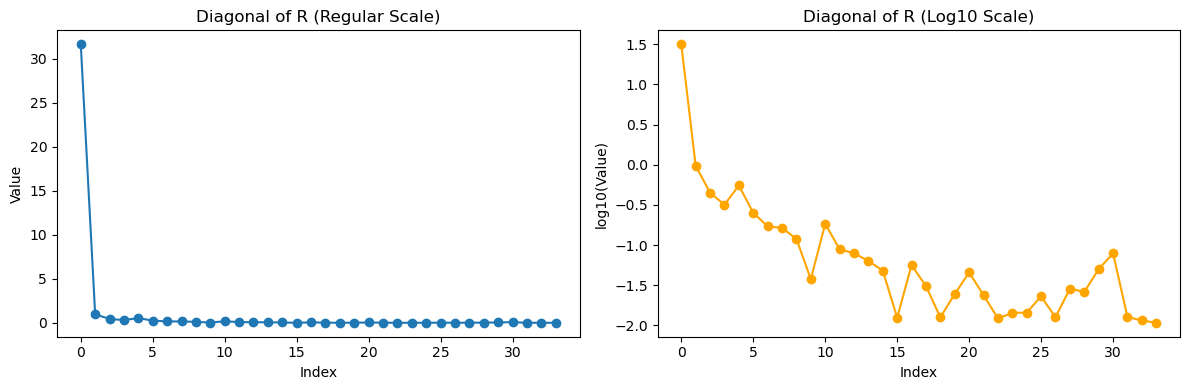

In [982]:
import matplotlib.pyplot as plt

diag_R = np.diag(R)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Regular scale
axs[0].plot(diag_R, marker='o')
axs[0].set_title('Diagonal of R (Regular Scale)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')

# Log scale
axs[1].plot(np.log10(np.abs(diag_R)), marker='o', color='orange')
axs[1].set_title('Diagonal of R (Log10 Scale)')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('log10(Value)')

plt.tight_layout()
plt.show()

## Forming candidate libary with noise level and plotting fits

noise_magnitude: 0.0
noise_percentage: 0.0
x_true: [   5.96035409    3.69423489    3.24767403    4.35258428   -5.29545011
  -80.09100328    1.78046123   29.86132877  -11.66373085  -17.81678086
   21.73168702   -0.55086875   -6.04120996   -1.94043965  142.4917658
   -1.04078415    2.03840402  -39.47314118   21.98726043    6.97722733
   -4.91901082   26.55919583   -5.74097877  -14.39977109  -12.09599207
    7.62732802  -12.97411069   15.45166768 -104.44775675   -2.40707285
    7.3525261    -6.26335681   19.15497625  -20.44404678   -2.26151712
   20.74310957   -8.81010789  -30.86014169   10.07841672   -5.57142373
   19.17461939   -1.36212183  -13.18234574   10.74213061   -5.42584738
   -2.8684765    19.36539658  -11.49761972   24.79576983    0.64820153
    1.17910538   -5.42437325    3.88116764   -1.58452038    6.86640169]
x_model: [   5.96035409    3.69423489    3.24767403    4.35258428   -5.29545011
  -80.09100328    1.78046123   29.86132877  -11.66373085  -17.81678086
   21.73168702   

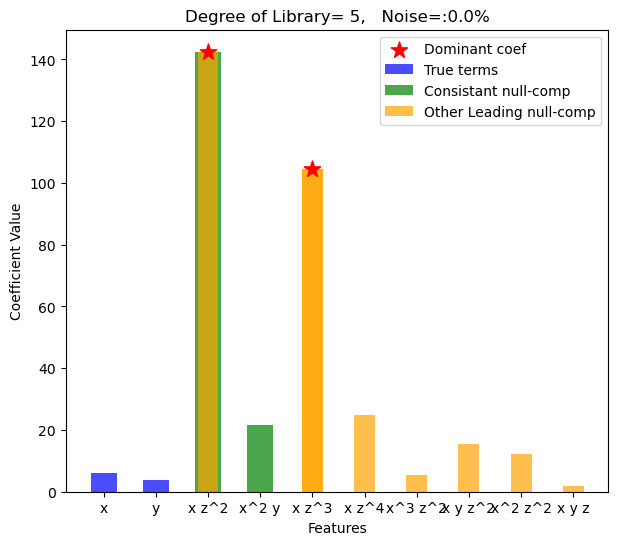

In [932]:
#Adding noise to the data matrix
noise_perc = 0.00

data_matrix_df = deepcopy(data_matrix_df_orig)
for col in data_matrix_df.columns:
    if col != 't':
        data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)
t_exact = data_matrix_df["t"]

#Defining candidate library
from dae_finder import PolyFeatureMatrix

poly_degree = 5

poly_feature_ob = PolyFeatureMatrix(poly_degree)

candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


#Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
# in the candidate library
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

#scaling the columns
from sklearn.preprocessing import normalize
scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

#Converting the scaled candidate library to a numpy array
A = scaled_cand_lib.to_numpy()
a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)



dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
y = dx_dt_series.to_numpy()
# y = dx_dt_lorenz

# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
ill_noise_perc = 0.00
other_noise_perc = 0.00

y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
# y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
# from sklearn.linear_model import Ridge
lin_model_true = LinearRegression(fit_intercept=True)
lin_model_true.fit(A, y)
# lin_model = LinearRegression()
lin_model_true.fit(scaled_cand_lib, dx_dt_series)
x = lin_model_true.coef_


lin_model = LinearRegression(fit_intercept=True)
# lin_model = Ridge(alpha=1, fit_intercept=True)
lin_model.fit(scaled_cand_lib, y_noisy)
x_model = lin_model.coef_

print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

print("x_true:", x)
print("x_model:", x_model)
print("x_model-x_true", x_model-(x))
print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]
# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])

# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component_2 = [(index, value) for index, value in enumerate(Vt[-2, :][1:])]
sorted_vt_last_component_2 = sorted(vt_last_component_2, key=lambda x: abs(x[1]))
sorted_vt_last_component_2 = sorted_vt_last_component_2[::-1]
sorted_vt_last_component_dict_2 = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component_2}
sorted_vt_last_component_df_2 = pd.DataFrame.from_dict(sorted_vt_last_component_dict_2, orient='index', columns=['Coefficient'])




import matplotlib.pyplot as plt

true_model_coef = ["x", "y"]
consistent_null = ["x z^2", "x^2 y"]
true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

# Extract the first four indices of vt_last_component
vt_dom_components = list(sorted_vt_last_component_df.index[:4]) + list(sorted_vt_last_component_df_2.index[:4]) 
dominant_model_coef = sorted_x_model_df.index[:5]
dominant_comp_plot=[]

all_comps = set(true_model_coef+vt_dom_components+consistent_null)
for feature in dominant_model_coef:
     if feature in all_comps:
        dominant_comp_plot.append(feature)
     


# Create a bar plot
fig, ax = plt.subplots(figsize=(7, 6)) 

# Plot the first two indices of sorted_x_model_df with smaller bar thickness

ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True terms', color='blue', alpha=0.7, width=0.5)

ax.bar(consistent_null, abs(sorted_x_model_df.loc[consistent_null]['Coefficient']), label='Consistant null-comp', color='green', alpha=0.7, width=0.5)

# Plot the first four indices of vt_last_component with smaller bar thickness
ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Other Leading null-comp', color='orange', alpha=0.7, width=0.4)

# Plot the first four indices of dominant_model_coef
# ax.bar(dominant_model_coef, abs(sorted_x_model_df.loc[dominant_model_coef]['Coefficient']), label='Dom-fit-comp', color='green', alpha=0.7, width=0.4)

# Add scatter plots for the true model coefficients
# ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='True term', color='red', marker='o', s=100)
# ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']),label='Lead null-comp', color='red', marker='*', s=150)
ax.scatter(dominant_comp_plot, abs(sorted_x_true_df.loc[dominant_comp_plot]['Coefficient']),label='Dominant coef', color='red', marker='*', s=150)


# Add labels and title
ax.set_ylabel('Coefficient Value')
ax.set_xlabel('Features')

ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, noise_perc*100) + '%')
ax.legend()

plt.show()
# file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)
# fig.savefig(os.path.join("figures", file_name), dpi=300)


In [1809]:
sorted_x_model_df.index[:6]

Index(['x^2 y', 'x z^2', 'x^3', 'x^2 y z', 'x^3 z', 'x y^2'], dtype='object')

In [1810]:
dominant_comp_plot

['x z^2']

## Making animation for different noise realizations

In [ ]:
import os


# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
frame_files = []
for ind in range(50):

    noise_perc = 0.05

    data_matrix_df = deepcopy(data_matrix_df_orig)
    for col in data_matrix_df.columns:
        if col != 't':
            data_matrix_df[col] += np.random.normal(0, noise_perc * data_matrix_df[col].std(), size=data_matrix_df[col].shape)
    t_exact = data_matrix_df["t"]

    #Defining candidate library
    from dae_finder import PolyFeatureMatrix

    poly_degree = 3

    poly_feature_ob = PolyFeatureMatrix(poly_degree)

    candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df.drop("t", axis=1))


    #Dropping 1 from the candidate library since we use fit_with_intercept flag instead of using constants directly
    # in the candidate library
    candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

    #scaling the columns
    from sklearn.preprocessing import normalize
    scaled_cand_lib = pd.DataFrame(normalize(candidate_lib_full, norm='l2', axis=0), columns=candidate_lib_full.columns)
    if '1' in scaled_cand_lib.columns:
            scaled_cand_lib['1'] = 1

    #Converting the scaled candidate library to a numpy array
    A = scaled_cand_lib.to_numpy()
    a = np.ones((A.shape[0], 1))
    A_design = np.hstack((a, A))

    U, S, Vt = np.linalg.svd(A_design, full_matrices=True)



    dx_dt = np.gradient(scaled_cand_lib['x'], t_exact)
    dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
    y = dx_dt_series.to_numpy()

    # y_noise_comp = A @ noise_comp
    # y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
    ill_noise_perc = 0.00
    other_noise_perc = 0.00

    y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
    # y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

    y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
    # from sklearn.linear_model import Ridge
    lin_model_true = LinearRegression(fit_intercept=True)
    lin_model_true.fit(A, y)
    # lin_model = LinearRegression()
    lin_model_true.fit(scaled_cand_lib, dx_dt_series)
    x = lin_model_true.coef_


    lin_model = LinearRegression(fit_intercept=True)
    # lin_model = Ridge(alpha=1, fit_intercept=True)
    lin_model.fit(scaled_cand_lib, y_noisy)
    x_model = lin_model.coef_

    # print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
    # print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

    # print("x_true:", x)
    # print("x_model:", x_model)
    # print("x_model-x_true", x_model-(x))
    # print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))

    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
    sorted_x_model_last = sorted_x_model_last[::-1]
    sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
    sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])


    # Create a tuple containing the index and value of each component of Vt[-1, :]
    x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

    # Sort the tuple based on the magnitude of the value
    sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
    sorted_x_true_last = sorted_x_true_last[::-1]
    sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
    sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])



    # Create a tuple containing the index and value of each component of Vt[-1, :]
    vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]
    # Sort the tuple based on the magnitude of the value
    sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
    sorted_vt_last_component = sorted_vt_last_component[::-1]
    sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
    sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])

    # Create a tuple containing the index and value of each component of Vt[-1, :]
    vt_last_component_2 = [(index, value) for index, value in enumerate(Vt[-2, :][1:])]
    sorted_vt_last_component_2 = sorted(vt_last_component_2, key=lambda x: abs(x[1]))
    sorted_vt_last_component_2 = sorted_vt_last_component_2[::-1]
    sorted_vt_last_component_dict_2 = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component_2}
    sorted_vt_last_component_df_2 = pd.DataFrame.from_dict(sorted_vt_last_component_dict_2, orient='index', columns=['Coefficient'])




    import matplotlib.pyplot as plt

    true_model_coef = ["x", "y"]
    consistent_null = ["x z^2", "x^2 y"]
    true_model_df = sorted_vt_last_component_df.loc[true_model_coef]

    # Extract the first four indices of vt_last_component
    vt_dom_components = list(sorted_vt_last_component_df.index[:4]) + list(sorted_vt_last_component_df_2.index[:4]) 
    dominant_model_coef = sorted_x_model_df.index[:5]
    dominant_comp_plot=[]

    all_comps = set(true_model_coef+vt_dom_components+consistent_null)
    for feature in dominant_model_coef:
        if feature in all_comps:
            dominant_comp_plot.append(feature)
        


    # Create a bar plot
    fig, ax = plt.subplots(figsize=(7, 6)) 

    # Plot the first two indices of sorted_x_model_df with smaller bar thickness

    ax.bar(true_model_coef, abs(sorted_x_model_df.loc[true_model_coef]['Coefficient']), label='True terms', color='blue', alpha=0.7, width=0.5)

    ax.bar(consistent_null, abs(sorted_x_model_df.loc[consistent_null]['Coefficient']), label='Consistant null-comp', color='green', alpha=0.7, width=0.5)

    # Plot the first four indices of vt_last_component with smaller bar thickness
    ax.bar(vt_dom_components, abs(sorted_x_model_df.loc[vt_dom_components]['Coefficient']), label='Other Leading null-comp', color='orange', alpha=0.7, width=0.4)

    # Plot the first four indices of dominant_model_coef
    # ax.bar(dominant_model_coef, abs(sorted_x_model_df.loc[dominant_model_coef]['Coefficient']), label='Dom-fit-comp', color='green', alpha=0.7, width=0.4)

    # Add scatter plots for the true model coefficients
    # ax.scatter(true_model_coef, abs(sorted_x_true_df.loc[true_model_coef]['Coefficient']), label='True term', color='red', marker='o', s=100)
    # ax.scatter(vt_dom_components, abs(sorted_x_true_df.loc[vt_dom_components]['Coefficient']),label='Lead null-comp', color='red', marker='*', s=150)
    ax.scatter(dominant_comp_plot, abs(sorted_x_true_df.loc[dominant_comp_plot]['Coefficient']),label='Top 5 Dominant coef', color='red', marker='*', s=150)


    # Add labels and title
    ax.set_ylabel('Coefficient Value')
    ax.set_xlabel('Features')

    ax.set_title('Degree of Library= {},   Noise=:{}'.format(poly_degree, noise_perc*100) + '%')
    ax.legend()


    # plt.show()
    file_name = "OLS_degree_{}_noise_{}.png".format(poly_degree, other_noise_perc*100)

    import matplotlib.animation as animation

    # Create a directory to save the frames if it doesn't exist
    frames_dir = "frames"
    os.makedirs(frames_dir, exist_ok=True)

    # Save each frame as an image
    frame_file = os.path.join(frames_dir, f"frame_{ind:03d}.png")
    fig.savefig(frame_file, dpi=300)
    plt.close(fig)
    frame_files.append(frame_file)



file_name = "figures/OLS_degree_{}_noise_{}.mp4".format(poly_degree, noise_perc*100)





image_files = frame_files  # List of image files to create a video from
import cv2

# Read the first image to get frame size
frame = cv2.imread(image_files[0])
height, width, layers = frame.shape
size = (width, height)

# Define the codec and create VideoWriter object
out = cv2.VideoWriter(file_name, cv2.VideoWriter_fourcc(*'mp4v'), 1, size)

for filename in image_files:
    img = cv2.imread(filename)
    out.write(img)

out.release()
print("Video created successfully!")


Video created successfully!


In [512]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])

sorted_x_model_df

,Coefficient
x z,-93.22771568
z^2,83.69406324
x z^2,78.31940317
x^2 y,70.58497457
y z,63.96051779
z^3,-54.51457123
x y^2,-50.06873386
y z^2,-49.47207219
x^2 z,42.81509611
z,-40.07926674


In [513]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])

sorted_x_true_df

,Coefficient
y,12.75894491
x,-12.40750533
x z,1.71472629
z^2,1.33148739
x z^2,1.10413538
z,-0.80582491
z^3,-0.77631164
y z,-0.76380803
x^3,-0.68458396
x y^2,0.29668802


In [514]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])


sorted_vt_last_component_df  # Display in descending order of magnitude

,Coefficient
x z,0.45686348
z^2,-0.41245947
x z^2,-0.39272060
z^3,0.30335435
y z,-0.29086028
x^2 y,-0.27366668
y z^2,0.20970943
x^3,0.19465124
z,0.18672244
x y^2,0.15018497


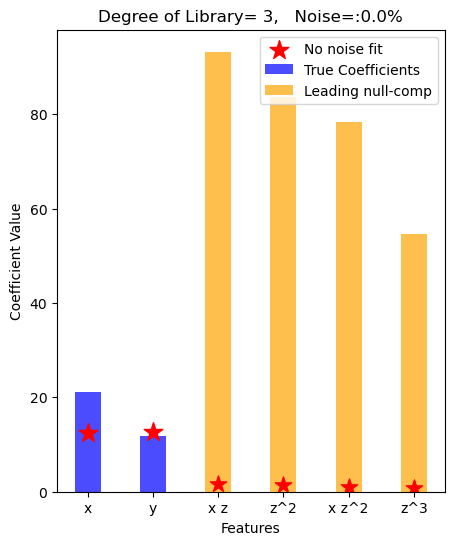

## Unscaled candidate library (Coefficient size based thresholding):

In [36]:
A = candidate_lib_full.to_numpy()

a = np.ones((A.shape[0], 1))
A_design = np.hstack((a, A))

U, S, Vt = np.linalg.svd(A_design, full_matrices=True)
S

array([8.08439694e+05, 3.37133225e+05, 1.17771177e+05, 1.01409515e+05,
       4.54359616e+04, 2.56728641e+04, 9.22118359e+03, 7.38454746e+03,
       3.22150780e+03, 1.85656863e+03, 9.61875844e+02, 7.48628844e+02,
       6.02282721e+02, 1.65440462e+02, 8.75836658e+01, 2.91495595e+01,
       2.30880146e+01, 1.46017892e+01, 2.75897942e+00, 1.68196457e+00])

In [37]:
np.linalg.norm(A_design.T @ U[:,0])/np.linalg.norm(A_design.T @ U[:,A_design.shape[1]-1]) 


np.float64(480652.0351582761)

In [38]:
np.linalg.norm(A.T @ U[:,0])/np.linalg.norm(A.T @ U[:,A_design.shape[1]-1]) 

np.float64(2120153.2870151103)

In [43]:

# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
# A = scaled_cand_lib.to_numpy()


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
#Calculating the derivative of x using finite differences
dx_dt = np.gradient(candidate_lib_full['x'], t_exact)
dx_dt_series = pd.Series(dx_dt, index=t_exact.index, name='dx/dt')
y = dx_dt_series.to_numpy()

# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
ill_noise_perc = 0.1
other_noise_perc = 0.0

y_noise_comp = U[:,A_design.shape[1]-1] * np.linalg.norm(y)*ill_noise_perc
# y_noise_comp = (U[:,A_design.shape[1]-1] +U[:,A_design.shape[1]-2]) * np.linalg.norm(y)*ill_noise_perc

y_noisy = y + y_noise_comp + np.random.randn(*y.shape) * np.linalg.norm(y) * other_noise_perc
# from sklearn.linear_model import Ridge
lin_model_true = LinearRegression(fit_intercept=True)
lin_model_true.fit(A, y)
# lin_model = LinearRegression()
lin_model_true.fit(candidate_lib_full, dx_dt_series)
x = lin_model_true.coef_


lin_model = LinearRegression(fit_intercept=True)
# lin_model = Ridge(alpha=1, fit_intercept=True)
lin_model.fit(candidate_lib_full, y_noisy)
x_model = lin_model.coef_

print("noise_magnitude:", np.linalg.norm(np.linalg.norm(y_noisy - y)))
print("noise_percentage:", np.linalg.norm(np.linalg.norm(y_noisy - y)/ np.linalg.norm(y)))

print("x_true:", x)
print("x_model:", x_model)
print("x_model-x_true", x_model-(x))
print("relative norm(x - lin_model.coef_)/norm(x):", np.linalg.norm(x - x_model)/ np.linalg.norm(x))


noise_magnitude: 120.98195912157898
noise_percentage: 0.09999999999999999
x_true: [-1.24075053e+01  1.14033949e+01 -2.54535435e-01 -1.38572592e-02
  1.19426729e-03  5.61597045e-02  3.13419000e-03 -2.62043048e-02
  1.40361470e-02 -4.46361492e-03 -1.59970895e-03  7.41344130e-04
  1.44096804e-03 -3.14016104e-04  1.07313752e-03 -8.28996860e-04
 -2.92907233e-05 -2.55695732e-04 -2.47875066e-04]
x_model: [-6.00059120e+00  4.86851166e+00 -1.36409308e+01 -8.25736961e-01
 -4.10955043e-01 -7.44978390e-01  4.58791030e-01  7.39012802e-01
  8.27784204e-01 -8.50224496e-02  1.35126812e-01  5.62812750e-02
 -6.96638273e-02 -1.78315742e-02  2.31673538e-02  9.65796837e-03
 -5.42210297e-03 -2.05011198e-02 -1.60095480e-02]
x_model-x_true [ 6.40691412e+00 -6.53488321e+00 -1.33863954e+01 -8.11879702e-01
 -4.12149310e-01 -8.01138094e-01  4.55656840e-01  7.65217107e-01
  8.13748057e-01 -8.05588347e-02  1.36726521e-01  5.55399308e-02
 -7.11047953e-02 -1.75175581e-02  2.20942163e-02  1.04869652e-02
 -5.39281224e-

In [44]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_model_last = [(index, value) for index, value in enumerate(lin_model.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_model_last = sorted(x_model_last, key=lambda x: abs(x[1]))
sorted_x_model_last = sorted_x_model_last[::-1]
sorted_x_model_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_model_last}
sorted_x_model_df = pd.DataFrame.from_dict(sorted_x_model_dict, orient='index', columns=['Coefficient'])

sorted_x_model_df

,Coefficient
z,-13.64093079
x,-6.00059120
y,4.86851166
z^2,0.82778420
x^2,-0.82573696
x z,-0.74497839
y z,0.73901280
y^2,0.45879103
x y,-0.41095504
x^2 y,0.13512681


In [45]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
x_true_last = [(index, value) for index, value in enumerate(lin_model_true.coef_)]

# Sort the tuple based on the magnitude of the value
sorted_x_true_last = sorted(x_true_last, key=lambda x: abs(x[1]))
sorted_x_true_last = sorted_x_true_last[::-1]
sorted_x_true_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_x_true_last}
sorted_x_true_df = pd.DataFrame.from_dict(sorted_x_true_dict, orient='index', columns=['Coefficient'])

sorted_x_true_df

,Coefficient
x,-12.40750533
y,11.40339487
z,-0.25453543
x z,0.05615970
y z,-0.02620430
z^2,0.01403615
x^2,-0.01385726
x^3,-0.00446361
y^2,0.00313419
x^2 y,-0.00159971


In [46]:
# Create a tuple containing the index and value of each component of Vt[-1, :]
vt_last_component = [(index, value) for index, value in enumerate(Vt[-1, :][1:])]

# Sort the tuple based on the magnitude of the value
sorted_vt_last_component = sorted(vt_last_component, key=lambda x: abs(x[1]))
sorted_vt_last_component = sorted_vt_last_component[::-1]
sorted_vt_last_component_dict = {candidate_lib_full.columns[index]: value for index, value in sorted_vt_last_component}
sorted_vt_last_component_df = pd.DataFrame.from_dict(sorted_vt_last_component_dict, orient='index', columns=['Coefficient'])


sorted_vt_last_component_df  # Display in descending order of magnitude

,Coefficient
z,-0.18610579
y,-0.09085191
x,0.08907281
z^2,0.01131322
x^2,-0.01128724
x z,-0.01113791
y z,0.01063851
y^2,0.00633482
x y,-0.00572995
x^2 y,0.00190086


In [ ]:
np.linalg.norm(A @ Vt[-1, :])

np.float64(0.14751820171521365)

## Finding highly correlated terms in the candidate library

In [15]:
from sklearn.linear_model import LinearRegression

# Extract the features z^3 and z^2 from the scaled candidate library
z_cubed = scaled_cand_lib['z^2']
z_squared = scaled_cand_lib['z^3']

# Perform linear regression
lin_model = LinearRegression()
lin_model.fit(z_squared.values.reshape(-1, 1), z_cubed)

# Get the coefficient
coefficient_corr = lin_model.coef_[0]
coefficient_corr

np.float64(0.9873734159695747)

In [16]:
lin_model.intercept_
intercept_corr = lin_model.intercept_
lin_model.score(z_squared.values.reshape(-1, 1), z_cubed)

0.9749062625634284

In [17]:
corr_dir_1 = scaled_cand_lib.columns.get_loc('z^2')
corr_dir_2 = scaled_cand_lib.columns.get_loc('z^3')

In [18]:
noise_perc = 0.01
U, S, Vt = np.linalg.svd(A, full_matrices=True)
# y_noise_comp = U[:,5-1] * noise_perc
# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
corr_dir = np.zeros(A.shape[1])
corr_dir[corr_dir_1] = 1
corr_dir[corr_dir_2] = -coefficient_corr

np.linalg.norm(A @ corr_dir )

NameError: name 'A' is not defined

In [757]:
S

array([1.72872323e+02, 1.17242134e+02, 7.67606302e+01, 4.23145959e+01,
       3.86256634e+01, 2.31880216e+01, 1.80738262e+01, 1.56347155e+01,
       1.44228678e+01, 7.25582140e+00, 6.46438543e+00, 5.13546258e+00,
       3.94933721e+00, 3.20860805e+00, 2.63811011e+00, 1.83792031e+00,
       1.52617289e+00, 9.67850395e-01, 8.72275185e-01, 7.13823812e-01,
       4.97756843e-01, 4.14565752e-01, 3.18742286e-01, 2.12528630e-01,
       1.66887441e-01, 1.42332068e-01, 9.21460855e-02, 6.37511572e-02,
       4.60391032e-02, 2.47718677e-02, 2.28707400e-02, 1.80354082e-02,
       1.41773548e-02, 8.90262114e-03])

In [758]:
np.std(A @ corr_dir)

np.float64(0.15836378988512995)

In [771]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
A = scaled_cand_lib.to_numpy()
A_appended = np.hstack((A, np.ones((A.shape[0], 1))))
lin_model.fit(A_appended, dx_dt_series)
print("x_model:", lin_model.coef_)
x = lin_model.coef_

x_model: [-1.24075053e+01  1.28409340e+01 -2.64895928e-01 -1.19569459e-01
  1.18820066e-02  1.72689512e+00  4.18480902e-02 -7.67521850e-01
  7.24780894e-01 -7.01572249e-01 -2.68209798e-01  2.28919286e-01
  3.04993229e-01 -9.58655736e-02  1.12181249e+00 -2.43002339e-01
 -1.05928647e-02 -2.26109358e-01 -5.31747437e-01  0.00000000e+00]


In [776]:
corr_dir = np.zeros(A_appended.shape[1])
corr_dir[corr_dir_1] = 1
corr_dir[corr_dir_2] = -coefficient_corr
corr_dir[-1] = -intercept_corr

np.linalg.norm(A_appended @ corr_dir )

np.float64(5.007902749333455)

In [763]:
np.linalg.norm(A.T @  U[:,A.shape[1]-1])

np.float64(0.10140039391239017)

In [844]:

# epsilon = 1e-2
# A = np.random.randn(num_data, 4)
# A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
A = scaled_cand_lib.to_numpy()
U, S, Vt = np.linalg.svd(A, full_matrices=True)


# y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc
# corr_dir = np.zeros(A.shape[1])
# corr_dir[z_squared_index] = 1
# corr_dir[z_cubed_index] = coefficient_corr



# x = np.random.randn(5)
# x[-2:] *= 0.01
# y = A @ x
y = dx_dt_series.to_numpy()
# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
noise_perc = 0
y_noise_comp = U[:,A.shape[1]-1] * np.std(y)*noise_perc
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
# lin_model = LinearRegression(fit_intercept=True)
lin_model = Ridge(alpha=0.1, fit_intercept=True)

lin_model.fit(A, y_noisy)
print("noise_magnitude:", np.linalg.norm(y_noise_comp))
print("x_true:", x)
print("x_model:", lin_model.coef_)
print("x_model-x_true", lin_model.coef_-(x))
print("norm(x - lin_model.coef_):", np.linalg.norm(x - lin_model.coef_))


noise_magnitude: 0.0
x_true: [-7.54403353e+00  1.00586852e+01 -2.06337676e-01  1.23483296e-01
  1.88482583e-02 -4.53363226e+00 -5.66686528e-02  1.86485696e+00
  4.32121935e-01  5.38669355e-01 -6.91608591e-01 -3.60958262e-02
 -6.58876375e-02 -1.26669828e-01 -1.49023134e-01  1.33275537e-01
  5.32882735e-02  3.36188266e-03 -4.07556630e-02 -9.52656500e-02
 -1.93793444e-01 -7.48247174e-02 -2.36630460e-01 -5.80632651e-02
  2.42137882e-02  8.07549980e-02  1.25977977e-01 -6.18651859e-02
  1.88810297e+00  1.10475521e-01 -3.04706804e-01  1.42025068e-01
 -2.06730170e-01 -2.01197431e-01 -1.16652740e+00  7.29716463e-01
  1.35093679e-01  2.16505958e-01  1.26957302e-01 -1.26921047e+00
 -2.44715659e-02 -1.08582137e-01  4.00136625e-01  7.51930082e-02
 -6.67255983e-02  1.66767633e-01  3.94920216e-01  6.81514956e-02
  1.63973190e+00 -4.08967672e-02 -5.70233007e-02 -1.96168544e-01
 -3.76948090e-02 -2.27349039e-01 -1.10516174e-01]
x_model: [-7.54403353e+00  1.00586852e+01 -2.06337676e-01  1.23483296e-01
  

In [90]:
S

array([2.09701983e+02, 1.30457447e+02, 7.98086028e+01, 4.30733836e+01,
       3.97318588e+01, 2.36967196e+01, 1.74512382e+01, 1.24399882e+01,
       9.18983321e+00, 5.72053015e+00, 3.94715003e+00, 3.54622168e+00,
       2.42577520e+00, 1.47002027e+00, 8.60678104e-01, 5.58801125e-01,
       3.62213833e-01, 2.45571245e-01, 1.47518202e-01])

In [ ]:
import numpy as np

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered matrix
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[4.35252981 4.12968842 2.92345172 1.54786262 0.01086226]


# SODAs - Sparse Optimization for Differential-Algebraic systems

<div>
<img src="attachment:34bc23d8-1c30-4599-8efd-06fe6aecffb6.png" width="10000000000"/>
</div>


## Lasso

- Using l1 penalty in cost function to enforce sparsity of model

### Using sympy to find factors of redundant feature and refine the library

In [421]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [422]:
feat_list

['S', 'E', 'ES', 'P', 't']

### Discovering algebraic equations

#### Discovering conservation laws

- Higher order monomials are not required to discover conservation laws

In [20]:
from dae_finder import sequentialThLin, AlgModelFinder
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=True)

algebraic_model_lasso.fit(data_matrix_df_smooth, scale_columns= True)

,model_id,'lasso'
,custom_model,False
,custom_model_ob,None
,alpha,0.1
,fit_intercept,True


In [21]:
#Best 10 models using R2 metrix
algebraic_model_lasso.best_models(5)

,E,ES,S,P
S,-0.00000000,0.00000000,NaN,-0.75928054
ES,-0.90000000,NaN,0.00000000,-0.00000000
P,0.00000000,-0.00000000,-0.23086403,NaN
E,NaN,-0.90000000,-1.25616334,0.10115787
r2- metric,0.99000000,0.99000000,0.91019772,0.77600418


In [22]:
algebraic_model_lasso.get_fitted_intercepts()

{'S': np.float64(3.194271549507994),
 'E': np.float64(1.9547534189339562),
 'ES': np.float64(1.8611795649921408),
 'P': np.float64(2.8398107343969357)}

#### Refining the candidate library using discovered equation

In [23]:
# def remove_paranth_from_feat(feature_list):
#     """
#     Utility function to remove the parenthesis from the name of the feature if they exists.
#     If either "[", or "]" are not present, the feature string is returned unchanged.
#     :param feature_list: ["[E]", "[ES]"]
#     :return: ["E", "ES"]
#     """
#     result_list = list(feature_list)
#     for ind, feat in enumerate(result_list):
#         if "[" in feat and "]" in feat:
#             result_list[ind] = feat.replace("[", "").replace("]", "")

#     return result_list


# def poly_to_scipy(exp_list):
#     """
#     Utility function to convert the power symbol "^" from monomial strings to scipy compatible "**"
#      symbol for power.
#     :param exp_list: ["A^2", "A*B^3"]
#     :return: ["A**2", "A*B**3"]
#     """
#     return [exp.replace(" ", "*").replace("^", "**") for exp in exp_list]


# def get_factor_feat(factor_exp, feat_dict):
#     """
#     Utility function to return the list of expressions from expr_list which has factor_exp as a factor
#     factor_exp: sympy expression eg: [ES]**2
#     feat_dict : {'[ES]*[S]^2': [ES]*[S]**2}
#     """
#     # for feat, feat_sym in feat_dict.items():
#         # print("factor_exp: ", factor_exp, ",feat: ", feat, ",feat_sym: ", feat_sym, ",div:", sympy.fraction(feat_sym / factor_exp))
#     return [feat for feat, feat_sym in feat_dict.items() if sympy.fraction(feat_sym / factor_exp)[1] == 1]


# def get_refined_lib(factor_exp, data_matrix_df_, candidate_library_, get_dropped_feat=False):
#     """
#     ****Warninig: This function won't work if there is paranthesis in the feature names.****
#     Utility function to get the refined library by removing all features in the candidate library which
#     have factor_exp as a factor.
    
#     :param factor_exp: sympy expression (or list/set of sympy expressions), e.g. S*ES or [ES]**2
#     :param data_matrix_df_ (pd.DataFrame): data matrix containing all the state variables as column labels
#     :param candidate_library_ (pd.DataFrame): candidate library whose columns are monomial strings like "[S]*[E]^2"
#     :param get_dropped_feat: if True, return (dropped_set, refined_df); else just return refined_df
#     :return: refined candidate‐library DataFrame (and optionally the set of dropped column names)
#     """
#     # 1) build a clean list of feature‐names (no brackets) and create matching Sympy symbols

#     raw_feats = list(data_matrix_df_.columns)
#     if any("[" in feat or "]" in feat for feat in raw_feats):
#         return get_refined_lib_2(factor_exp, data_matrix_df_, candidate_library_, get_dropped_feat)
#     # clean_feats = remove_paranth_from_feat(raw_feats)
#     symbols = sympy.symbols(" ".join(raw_feats))
#     sym_map = dict(zip(raw_feats, symbols))

#     # 2) (re-)parse factor_exp into this local symbol space
#     def _parse(fe):
#         # turn anything (sympy or string) into a sympified expression
#         return sympy.sympify(str(fe), locals=sym_map)

#     if isinstance(factor_exp, (list, set)):
#         factors = [_parse(fe) for fe in factor_exp]
#     else:
#         factors = [_parse(factor_exp)]

#     # 3) build your candidate‐feature dict by parsing each candidate column
#     raw_cand = list(candidate_library_.columns)
#     cand_strs = remove_paranth_from_feat(poly_to_scipy(raw_cand))
#     candid_feat_dict = {
#         raw: sympy.sympify(expr_str, locals=sym_map)
#         for raw, expr_str in zip(raw_cand, cand_strs)
#     }
#     print(candid_feat_dict)


#     dropped_feats = set()
#     for factor_ in factors:
#         dropped_feats = dropped_feats.union(set(get_factor_feat(factor_, candid_feat_dict)))

#     print("Dropped features: ", dropped_feats)
#     if get_dropped_feat:
#         return (dropped_feats, candidate_library_.drop(dropped_feats, axis=1))
#     else:
#         return candidate_library_.drop(dropped_feats, axis=1)

In [24]:
features_to_remove = {E}
from dae_finder import get_refined_lib_stable

features_to_remove, refined_candid_lib = get_refined_lib_stable(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)


#### Searching for remaining algebraic equations

In [25]:
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                       fit_intercept=False, alpha=0.2)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)

/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.681e-02, tolerance: 1.547e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.198e-02, tolerance: 1.416e-02
  model = cd_fast.enet_coordinate_descent(
/Users/manujayadharan/opt/anaconda3/envs/battery_env_1/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the nu

,model_id,'lasso'
,custom_model,False
,custom_model_ob,None
,alpha,0.2
,fit_intercept,False


In [26]:
algebraic_model_lasso.best_models()

,S P,S,P^3,S ES P,ES P^3,S ES^2 P,P^4,S^2 P,P^2,S ES,...,P^5,ES P,ES,ES^2 P^3,S^2 P^3,S^5,S^3 P^2,S^4 P,ES P^4,P
S,0.00000000,NaN,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.72754149,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES,0.00000000,0.72239535,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,NaN,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.06670521
P,0.00000000,0.00000000,0.00000000,0.00000000,0.08022729,0.00000000,0.00000000,0.00000000,1.90717110,-0.00000000,...,0.00000000,0.01936972,0.00932376,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,NaN
S^2,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
S ES,0.00000000,0.35712749,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,NaN,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES^2,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.59440447,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
ES P,0.57995879,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,NaN,0.13446716,0.00000000,0.00000000,-0.00000000,0.00000000,0.00000000,0.00000000,0.22645777
P^2,0.00000000,0.00000000,2.19921916,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,NaN,-0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.06687234,0.28473156
S^3,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000
S^2 ES,0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,-0.00000000,0.00000000,...,-0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.00000000,0.00000000


In [69]:

best_models_full = algebraic_model_lasso.best_models()

#### Converting the best models to sympy expressions for LHS and RHS

- This will allow us to cancel the common terms on the right hand side if the intercept is close to 0.
- Later on, we will used the simplified LHS and RHS for OLS fit

In [70]:
from dae_finder import get_simplified_equation_list

intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                             global_feature_list=data_matrix_df.columns,
                             intercept_dict= intercept_dictionary,
                             simplified = True)

NameError: name 'S' is not defined

In [32]:
simplified_equations

{'[S] [P]': {'lhs': [S],
  'rhs': 0.10766246971546*[ES]**2 + 0.337476566912654*[ES]*[S] + 0.579958788676024*[ES]},
 '[S]': {'lhs': [S],
  'rhs': 0.357127490613468*[ES]*[S] + 0.722395352276884*[ES]},
 '[P]^3': {'lhs': [P], 'rhs': 0.0762021149976661*[P]**2 + 2.19921916496576},
 '[S] [ES] [P]': {'lhs': [ES]*[S],
  'rhs': 0.366439587659445*[ES]**3 + 0.236123825493933*[ES]**2*[S] + 0.349230278258152*[S]},
 '[ES] [P]^3': {'lhs': [ES]*[P]**2,
  'rhs': 0.139458741396907*[ES]*[P]**3 + 1.24953585101755*[ES]*[P] + 0.0802272869475862},
 '[S] [ES]^2 [P]': {'lhs': [ES]**2*[S],
  'rhs': 0.288921704639404*[ES]**4 + 0.243152213827764*[ES]*[S] + 0.325126962931269*[S]**2},
 '[P]^4': {'lhs': [P], 'rhs': 0.0599240248010286*[P]**2 + 2.39472261918809},
 '[S]^2 [P]': {'lhs': [S],
  'rhs': 0.606913750296571*[ES]**2 + 0.208691207786207*[ES]*[S] + 0.22130997220599*[ES]},
 '[P]^2': {'lhs': [P], 'rhs': 0.102897606098532*[P]**2 + 1.90717109928867},
 '[S] [ES]': {'lhs': [ES]*[S],
  'rhs': 0.0573430975126995*[ES]**4 

#### Creating a list of features that appears on the LHS and RHS of the reduced best fits

In [33]:
from dae_finder import construct_reduced_fit_list

reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

reduced_relationship_features

***Warning: exception occured while trying to find the monomials of 1.11128971552691:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 3.16657148635415:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators


[['[S]', '[ES]^2', '[S] [ES]', '[ES]'],
 ['[S]', '[S] [ES]', '[ES]'],
 ['[P]', '[P]^2', None],
 ['[S] [ES]', '[ES]^3', '[S] [ES]^2', '[S]'],
 ['[ES] [P]^2', '[ES] [P]^3', '[ES] [P]', None],
 ['[S] [ES]^2', '[ES]^4', '[S] [ES]', '[S]^2'],
 ['[P]', '[P]^2', None],
 ['[S]', '[ES]^2', '[S] [ES]', '[ES]'],
 ['[P]', '[P]^2', None],
 ['[S] [ES]', '[ES]^4', '[S] [ES]^2', '[S]'],
 ['[S] [ES] [P]', '[ES]^3 [P]', '[S] [P]', '[S]'],
 ['[P]', '[P]^2', None],
 ['[S]', '[ES]^2', '[S] [ES]', None],
 ['[S] [ES]^2', '[ES]^5', '[S] [ES]', '[S]^2'],
 ['[ES]', '[ES]^2', None],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[ES]^4', '[ES]^3', '[S] [ES]', '[S]'],
 ['[ES]^3', '[ES]^2', '[S] [ES]', '[S]'],
 ['[ES]^3', '[ES]^2', '[S]'],
 ['[ES]^2', '[ES]', '[S]'],
 ['[S] [ES]^2 [P]', '[ES]^3 [P]', '[S]^2 [P]', '[S]'],
 ['[S] [P]', '[ES]^2 [P]', '[S] [ES] [P]', None],
 ['[ES]^3', '[S] [ES]', '[S]'],
 ['[S]', '[ES]^2', '[S] [ES]'],
 ['[ES]^2', '[S]'],
 ['[ES]', '[ES]^2', None],
 ['[ES]^2', '[ES]^3', '[ES]', '[S]'],
 ['[ES]^2',

#### Linear fit between features present in the reduced version of the best relationship

In [34]:
from sklearn.linear_model import LinearRegression

#Removing None from reduced relationship features if it is present. Whenever a constant appears in either LHS or RHS of the relationship,
# while converting the sympy symbol to feature name corresponding to the canddiate library, a None is returned. 

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
lin_model.score(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])

1.0

In [35]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[ES]^2': -1.0921794866350556e-16,
 '[S] [ES]': 0.5000000000000001,
 '[ES]': 0.614371917008699}

In [36]:
lin_model.intercept_

-4.440892098500626e-16

In [37]:
df_ = algebraic_model_lasso.best_models()
{key_: value_ for key_, value_ in dict(df_["[S] [P]"]).items() if abs(value_)>0.01}

{'[ES] [P]': 0.5799587886760244,
 '[S] [ES] [P]': 0.3374765669126542,
 '[ES]^2 [P]': 0.10766246971546008,
 'r2- metric': 0.973078730487555}

In [38]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[["[ES]", "[S] [ES]", "[ES]^2"]], candidate_lib_full["[S]"])

LinearRegression()

In [39]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

{'[ES]': 0.6143719170086982,
 '[S] [ES]': 0.5000000000000001,
 '[ES]^2': 1.6386291029098287e-16}

### Discovering dynamic equations

#### Refined candidate library is able to find the dynamic ODE
- Combining the discovered ODE with the algebraic equations, we get the full description of the system. 

In [71]:
features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

#Lasso requires scaling of library terms
from sklearn.preprocessing import StandardScaler
s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_refined_lib = pd.DataFrame(s_scaler.fit_transform(refined_candid_lib), columns=s_scaler.feature_names_in_)

{'S': S, 'E': E, 'ES': ES, 'P': P, 'S^2': S**2, 'S E': E*S, 'S ES': ES*S, 'S P': P*S, 'E^2': E**2, 'E ES': E*ES, 'E P': E*P, 'ES^2': ES**2, 'ES P': ES*P, 'P^2': P**2, 'S^3': S**3, 'S^2 E': E*S**2, 'S^2 ES': ES*S**2, 'S^2 P': P*S**2, 'S E^2': E**2*S, 'S E ES': E*ES*S, 'S E P': E*P*S, 'S ES^2': ES**2*S, 'S ES P': ES*P*S, 'S P^2': P**2*S, 'E^3': E**3, 'E^2 ES': E**2*ES, 'E^2 P': E**2*P, 'E ES^2': E*ES**2, 'E ES P': E*ES*P, 'E P^2': E*P**2, 'ES^3': ES**3, 'ES^2 P': ES**2*P, 'ES P^2': ES*P**2, 'P^3': P**3, 'S^4': S**4, 'S^3 E': E*S**3, 'S^3 ES': ES*S**3, 'S^3 P': P*S**3, 'S^2 E^2': E**2*S**2, 'S^2 E ES': E*ES*S**2, 'S^2 E P': E*P*S**2, 'S^2 ES^2': ES**2*S**2, 'S^2 ES P': ES*P*S**2, 'S^2 P^2': P**2*S**2, 'S E^3': E**3*S, 'S E^2 ES': E**2*ES*S, 'S E^2 P': E**2*P*S, 'S E ES^2': E*ES**2*S, 'S E ES P': E*ES*P*S, 'S E P^2': E*P**2*S, 'S ES^3': ES**3*S, 'S ES^2 P': ES**2*P*S, 'S ES P^2': ES*P**2*S, 'S P^3': P**3*S, 'E^4': E**4, 'E^3 ES': E**3*ES, 'E^3 P': E**3*P, 'E^2 ES^2': E**2*ES**2, 'E^2 ES P'

In [44]:
#Using Lasso directly to fit the dP/dt against the refined library

from sklearn.linear_model import Lasso
alg_lasso = Lasso(fit_intercept=True, alpha=0.3)
alg_lasso.fit(X=scaled_refined_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])
alg_lasso.score(X=scaled_refined_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [45]:
dict(zip(alg_lasso.feature_names_in_, alg_lasso.coef_))

In [46]:
from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(X=candidate_lib_full[["[ES]" ]],  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [47]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [48]:
lin_model.intercept_

## **Sequential Thresholding (Currently not working as intended) 

- Using sequential thresholding to enforce sparsity of model

### Using sympy to find factors of redundant feature and refine the library

In [131]:
import sympy

from dae_finder import get_refined_lib, remove_paranth_from_feat

# Adding the state variables as scipy symbols
feat_list = list(data_matrix_df.columns)
feat_list_str = ", ".join(remove_paranth_from_feat(data_matrix_df.columns))
exec(feat_list_str+ "= sympy.symbols("+str(feat_list)+")")

In [132]:
feat_list

### Discovering algebraic equations

#### Discovering conservation laws

- Higher order monomials are not required to discover conservation laws

In [51]:
from dae_finder import sequentialThLin, AlgModelFinder
from sklearn.linear_model import LinearRegression

# lin_reg_model = LinearRegression
# lin_reg_model_arg = {"fit_intercept": True}
# seq_th_model = sequentialThLin(custom_model=True,
#                                custom_model_ob = lin_reg_model,
#                                custom_model_arg= lin_reg_model_arg,
#                               coef_threshold=0.1)


seq_th_model = sequentialThLin(model_id="LR",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(data_matrix_df_smooth, scale_columns= True)

In [52]:
#Best 10 models using R2 metrix
algebraic_model_th.best_models()

In [53]:
algebraic_model_th.get_fitted_intercepts()

- Note that the above algebraic relationship corresponds to the conservation law.

#### Refining the candidate library using discovered equation

In [54]:
features_to_remove = {E}

features_to_remove, refined_candid_lib = get_refined_lib(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)


#### Searching for remaining algebraic equations

In [55]:
seq_th_model = sequentialThLin(model_id="lasso",coef_threshold=0.1, fit_intercept=True, alpha=0.3)

algebraic_model_th = AlgModelFinder(custom_model=True, custom_model_ob= seq_th_model)

algebraic_model_th.fit(refined_candid_lib, scale_columns= True)

In [56]:
algebraic_model_th.best_models()

In [59]:
best_model = algebraic_model_th.best_models(1)

best_model_lhs = best_model.columns[0]
best_model_trimmed = best_model[abs(best_model[best_model_lhs]) > 0.1]
best_model_rhs_features = best_model_trimmed[:-1].index

best_model_trimmed.loc[best_model_rhs_features]

In [148]:


from sklearn.linear_model import LinearRegression

lin_model = LinearRegression()
lin_model.fit(candidate_lib_full[best_model_rhs_features], candidate_lib_full[best_model_lhs])
lin_model.score(candidate_lib_full[best_model_rhs_features], candidate_lib_full[best_model_lhs])

In [149]:
dict(zip(lin_model.feature_names_in_, lin_model.coef_))

In [150]:
lin_model.intercept_

### Conclusion

For this simple MM model, we have the following algebraic relationship:
1. [E] + [ES] = E_0
2. [ES] =  k*[E][S]


- We get the first relation from finding the discovery of conservation law.
- From the first relation, we decide to drop [E], and all of it's factors from the library. Consequently, relation 2 will exist in the form [ES] = k*(E_0 - [ES])[S]. Ie, we are looking for a relationship involving [ES], [S], and [S][ES]. This would have been different if we removed [ES] instead of [E] in the first step.
- Also note that sometimes, we get a relationship where we can cancel out certain terms. For example, if we get the best relationship to be [S]




- Note that after removing [E] and it's factors from the candidate library, the relation w

### Discovering dynamic equations

#### Refined candidate library is able to find the dynamic ODE
- Combining the discovered ODE with the algebraic equations, we get the full description of the system. 

In [424]:
features_to_remove = {E, S*ES}

features_to_remove, refined_candid_lib = get_refined_lib_stable(features_to_remove, data_matrix_df,
                                                  candidate_lib_full, get_dropped_feat=True)

In [44]:
from dae_finder import sequentialThLin

seq_th_model = sequentialThLin(fit_intercept=True, coef_threshold=0.1)

seq_th_model.fit(X=refined_candid_lib,  y=data_matrix_df_smooth_appended['d([P]) /dt'])

In [45]:
dict(zip(seq_th_model.feature_names_in_, seq_th_model.coef_))

In [46]:
seq_th_model.intercept_

In [58]:
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]))

x = np.random.randn(5)
y = A @ x
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-x)

[ 0.44211545  0.0420531   0.22820331  1.0579962  -1.508809  ]
[ 0.44211545  0.0420531   0.22820331 -0.39192436 -0.78384872]
[-1.11022302e-16  6.10622664e-16  2.22044605e-16 -1.44992056e+00
  7.24960280e-01]


In [59]:
import numpy as np

# Compute the singular values of A
singular_values = np.linalg.svd(A, compute_uv=False)
print(singular_values)

[8.76598147e+00 3.24544701e+00 2.89421507e+00 1.76355235e+00
 1.36744278e-16]


In [469]:
epsilon = 1e-2
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]+epsilon))

x = np.random.randn(5)
y = A @ x
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-x)

[-2.26331652 -0.86905033  1.88702648 -0.9834788   1.81099649]
[-2.26331652 -0.86905033  1.88702648  0.52770284  1.05540567]
[-4.44089210e-16  1.11022302e-16  1.77635684e-15  1.51118163e+00
 -7.55590816e-01]


In [61]:
import numpy as np

# Compute the singular values of A
singular_values = np.linalg.svd(A, compute_uv=False)
print(singular_values)

[4.71721991 3.47059791 2.63359047 2.12675059 0.00912799]


In [68]:
A @(noise_comp)

array([ 0.36264024, -0.44719651,  0.50530859,  0.28472882, -0.20388595,
       -1.07543856,  0.58199507, -0.39797753,  0.34550932,  0.35574489])

,S,E,ES,P,S^2,S E,S ES,S P,E^2,E ES,...,E ES^3 P,E ES^2 P^2,E ES P^3,E P^4,ES^5,ES^4 P,ES^3 P^2,ES^2 P^3,ES P^4,P^5
0,2.50000000,0.65906583,1.34093417,0.00000000,6.25000000,1.64766459,3.35233541,0.00000000,0.43436777,0.88376390,...,0.00000000,0.00000000,0.00000000,0.00000000,4.33548093,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
1,2.08660414,0.74124577,1.25875423,0.41339586,4.35391683,1.54668650,2.62652178,0.86259351,0.54944529,0.93304625,...,0.61115473,0.20071340,0.06591762,0.02164845,3.16012827,1.03783878,0.34084355,0.11193870,0.03676253,0.01207343
2,1.70167834,0.83861216,1.16138784,0.79832166,2.89570917,1.42704815,1.97630853,1.35848668,0.70327036,0.97395397,...,1.04874739,0.72089420,0.49553253,0.34062209,2.11293615,1.45240258,0.99836110,0.68625937,0.47172504,0.32425716
3,1.35034056,0.95285275,1.04714725,1.14965944,1.82341963,1.28667572,1.41400540,1.55243177,0.90792837,0.99777714,...,1.25781934,1.38095562,1.51614653,1.66457218,1.25903781,1.38229338,1.51761526,1.66618469,1.82929857,2.00838074
4,1.03803675,1.08413125,0.91586875,1.46196325,1.07752030,1.12536808,0.95070543,1.51757158,1.17534056,0.99292193,...,1.21763758,1.94366429,3.10259057,4.95253645,0.64441584,1.02865424,1.64199804,2.62105327,4.18387846,6.67855140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.04280736,1.93266907,0.06733093,3.95719264,0.00183247,0.08273247,0.00288226,0.16939698,3.73520973,0.13012841,...,0.00233447,0.13720222,8.06368765,473.92134036,0.00000138,0.00008133,0.00477989,0.28092528,16.51062042,970.36687198
116,0.02587558,1.95875150,0.04124850,3.97412442,0.00066955,0.05068384,0.00106733,0.10283279,3.83670745,0.08079556,...,0.00054632,0.05263547,5.07121309,488.59068148,0.00000012,0.00001150,0.00110843,0.10679248,10.28901917,991.30499970
117,0.01555695,1.97499488,0.02500512,3.98444305,0.00024202,0.03072489,0.00038900,0.06198577,3.90060476,0.04938499,...,0.00012303,0.01960466,3.12390514,497.77888435,0.00000001,0.00000156,0.00024821,0.03955131,6.30230603,1004.24139861
118,0.00932213,1.98494082,0.01505918,3.99067787,0.00008690,0.01850387,0.00014038,0.03720161,3.93999007,0.02989158,...,0.00002705,0.00716875,1.89971667,503.42439334,0.00000000,0.00000021,0.00005439,0.01441261,3.81933667,1012.12316465


In [ ]:
Ay_noise_comp

array([-0.29052112, -0.34115095,  0.57977612,  0.1788137 ,  0.16581597,
       -0.38728324,  0.13640929,  0.12838519, -0.30818099,  0.35149652])

In [544]:
A.T

array([[ 0.19311844,  1.31613634,  0.58757181,  1.43040675, -2.07696504,
         0.72687466,  0.62950774, -1.38027882, -1.01892171, -1.2319352 ],
       [ 0.13146344,  1.33325043,  0.41394098, -0.16284503,  0.25621011,
         0.99462396, -0.13976832,  0.3967805 ,  1.26603267, -1.71629237],
       [-0.68823225, -1.29238686,  0.39793819,  1.42512476,  1.09232482,
        -1.08099631,  1.02743681, -0.84411895, -0.57793953, -1.0020245 ],
       [ 0.0677972 , -0.87374433,  0.14471704,  0.83772095, -0.11236926,
        -0.46854552,  1.1330332 ,  0.98070403,  0.00861809, -1.52022415],
       [ 0.13606226, -1.7468497 ,  0.28903924,  1.67705111, -0.22464874,
        -0.9358344 ,  2.26611381,  1.96075781,  0.01792874, -3.04077732]])

In [553]:
np.linalg.norm(A @ Vt[-1,:]/np.linalg.norm(A @ Vt[-1,:]) - U[:,5-1])


np.float64(1.056386637301658e-12)

In [575]:
num_data = 10 


epsilon = 1e-2
A = np.random.randn(num_data, 4)
A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(num_data, 1) * epsilon))
U, S, Vt = np.linalg.svd(A, full_matrices=True)

noise_perc = 0.01
# y_noise_comp = U[:,5-1] * noise_perc
y_noise_comp = (np.random.randn(num_data) + U[:,5-1]) * noise_perc



x = np.random.randn(5)
x[-2:] *= 0.01
y = A @ x
# y_noise_comp = A @ noise_comp
# y_noise_comp = noise_perc* y_noise_comp/np.linalg.norm(y_noise_comp)
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y_noisy)
print("noise_magnitude:", np.linalg.norm(y_noise_comp))
print("x_true:", x)
print("x_model:", lin_model.coef_)
print("x_model-x_true", lin_model.coef_-(x))


noise_magnitude: 0.02378079571175726
x_true: [-0.81130001  0.45008474  0.60373543  0.00956119 -0.01848691]
x_model: [-0.80561388  0.45261876  0.6025693   0.19445389 -0.11237669]
x_model-x_true [ 0.00568613  0.00253402 -0.00116613  0.1848927  -0.09388977]


In [561]:
import numpy as np

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered matrix
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[4.35252981 4.12968842 2.92345172 1.54786262 0.01086226]


In [562]:
lin_model.rank_

5

In [563]:
import pandas as pd

# Convert A to a DataFrame for easier computation of correlation matrix
A_df = pd.DataFrame(A)

# Compute the correlation matrix
correlation_matrix = A_df.corr()

print(correlation_matrix)

            0           1          2           3           4
0  1.00000000 -0.40050253 0.05000894 -0.39403302 -0.39140080
1 -0.40050253  1.00000000 0.40415878 -0.08085084 -0.08348842
2  0.05000894  0.40415878 1.00000000  0.03894679  0.03505211
3 -0.39403302 -0.08085084 0.03894679  1.00000000  0.99996379
4 -0.39140080 -0.08348842 0.03505211  0.99996379  1.00000000


In [468]:
import numpy as np

# Compute the SVD of scaled_cand_lib
U, S, Vt = np.linalg.svd(refined_candid_lib, full_matrices=False)

# U contains the left singular vectors
# S contains the singular values
# Vt contains the right singular vectors (transposed)
print("Singular values:", S)

Singular values: [3.76937062e+03 1.50220768e+03 3.29093268e+02 1.78539925e+02
 1.27453421e+02 6.83774110e+01 4.97388313e+01 2.13711630e+01
 1.85739039e+01 8.89297185e+00 5.83165622e+00 4.48271809e+00
 2.91782626e+00 2.33051333e+00 1.42847578e+00 8.55847246e-01
 3.68804076e-01 2.83815672e-01 1.87960618e-01 1.07524825e-01
 9.77903158e-02 5.29182622e-02 3.97281656e-02 2.30302075e-02
 7.28706545e-03 5.66249086e-03 3.08715869e-03 2.41850279e-03
 2.14030203e-03 7.95563278e-04 3.28571431e-04 2.33780130e-04
 1.54834692e-04 3.55104685e-05 5.77509123e-06]


In [427]:
U.shape

(120, 35)

In [432]:
refined_candid_lib.to_numpy()

array([[2.50000000e+00, 1.34093417e+00, 3.67584454e-18, ...,
        8.93071681e-53, 2.44813858e-70, 6.71097586e-88],
       [2.08660414e+00, 1.25875423e+00, 4.13395861e-01, ...,
        1.11938699e-01, 3.67625339e-02, 1.20734286e-02],
       [1.70167834e+00, 1.16138784e+00, 7.98321662e-01, ...,
        6.86259374e-01, 4.71725039e-01, 3.24257155e-01],
       ...,
       [1.55569469e-02, 2.50051228e-02, 3.98444305e+00, ...,
        3.95513085e-02, 6.30230603e+00, 1.00424140e+03],
       [9.32212750e-03, 1.50591774e-02, 3.99067787e+00, ...,
        1.44126062e-02, 3.81933667e+00, 1.01212316e+03],
       [5.57476285e-03, 9.03293989e-03, 3.99442524e+00, ...,
        5.20021299e-03, 2.29956827e+00, 1.01688417e+03]], shape=(120, 35))

In [451]:
A= refined_candid_lib.to_numpy()
U, S, Vt = np.linalg.svd(A, full_matrices=True)

null_vector = Vt[-1, :]
null_vector = null_vector / np.linalg.norm(null_vector)

In [459]:
left_singular_calculated = A @ null_vector
left_singular_calculated = left_singular_calculated / np.linalg.norm(left_singular_calculated)

In [460]:
sum(left_singular_calculated**2)

np.float64(1.0)

In [462]:
left_sing_val = U[:,len(Vt)-1]/ np.linalg.norm(U[:,len(Vt)-1])

In [ ]:
noise_perc = 0.1
noise_comp = np.zeros(5)
noise_comp[-2:] = noise_perc * np.array([-2,1])

epsilon = 1e-1
A = np.random.randn(10, 4)
A = np.hstack((A, 2 * A[:, [3]]+np.random.randn(10, 1) * epsilon))

x = np.random.randn(5)
y = A @ x
y_noise_comp = A @ noise_comp
y_noisy = y + y_noise_comp
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(A, y_noisy)
print(x)
print(lin_model.coef_)
print(lin_model.coef_-(x+noise_comp))
print(lin_model.coef_-(x))

np.float64(3.335167871765514e-11)

In [ ]:
import numpy as np  

# Mean centering the matrix A
A_mean_centered = A - np.mean(A, axis=0)

# Compute the singular values of the mean-centered A
singular_values_mean_centered = np.linalg.svd(A_mean_centered, compute_uv=False)
print(singular_values_mean_centered)

[6.67527569 3.24880785 2.31953933 1.69924555 0.084342  ]


In [303]:
A

array([[ 0.74134902, -0.49343591, -0.21944168,  0.53821006, 11.07642012],
       [-0.02259903,  1.1659993 ,  0.09316035, -1.55833025,  6.88333951],
       [ 0.49899651,  1.024182  ,  0.2446669 , -1.41374138,  7.17251723],
       [-0.15672402, -0.31124274, -0.91728008,  2.94966516, 15.89933033],
       [-0.46791149, -0.64190884,  0.39359561,  0.37443731, 10.74887463],
       [ 0.65055032, -0.95533897,  0.46909633,  1.89059893, 13.78119785],
       [ 0.02802865, -0.81087566, -1.53936755,  1.11908526, 12.23817052],
       [-1.21697623, -0.87783838,  0.52622272, -0.10128612,  9.79742776],
       [ 0.10705219,  0.74368998,  0.43246613,  0.47456948, 10.94913895],
       [-1.10850115, -0.63026288, -0.60539585,  0.84982779, 11.69965558]])

In [304]:
noise_comp

array([0. , 0. , 0. , 0.1, 0.2])

In [818]:
import pysindy

ModuleNotFoundError: No module named 'pysindy'

In [819]:
!pip install pysindy

  Using cached pysindy-1.7.5-py3-none-any.whl.metadata (22 kB)
Using cached pysindy-1.7.5-py3-none-any.whl (121 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 MB 27.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [pysindy]
